# Data Wrangling for Santa Clara Master Gardener Club by Michelle Petersen

In [171]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import json
import geojson
import shapefile
import requests
from bs4 import BeautifulSoup
import difflib
import geopandas as gpd
import urllib2
import matplotlib.pyplot as plt
from timeit import default_timer as timer

## Gather

In [143]:
df = gpd.read_file('ZillowNeighborhoods-CA/ZillowNeighborhoods-CA.shp')
print(df)

     State          County            City                         Name  \
0       CA       Riverside         Menifee                     Sun City   
1       CA     Santa Clara        San Jose                       Alviso   
2       CA           Marin      San Rafael                Santa Venetia   
3       CA           Marin      San Rafael                    Marinwood   
4       CA     Los Angeles   Santa Clarita                      Newhall   
5       CA     Los Angeles     Los Angeles                      Tujunga   
6       CA         Ventura          Oxnard                     Cabrillo   
7       CA     Los Angeles     Los Angeles                 Shadow Hills   
8       CA     Los Angeles     Los Angeles                       Sylmar   
9       CA   San Francisco   San Francisco                     Presidio   
10      CA     Los Angeles   Santa Clarita               Canyon Country   
11      CA         Alameda         Alameda                     East End   
12      CA       San Mate

In [3]:
df.to_csv('California neighborhoods.csv')

In [4]:
sc_df = df[df['County'] == 'Santa Clara']
print(sc_df)

     State       County           City                      Name RegionID  \
1       CA  Santa Clara       San Jose                    Alviso     8075   
22      CA  Santa Clara       San Jose             Cambrian Park   114074   
42      CA  Santa Clara      Cupertino          Rancho Rinconada   117559   
43      CA  Santa Clara       Campbell                 San Tomas   117891   
68      CA  Santa Clara       San Jose                 Berryessa   113736   
74      CA  Santa Clara       San Jose                 Evergreen   115003   
94      CA  Santa Clara  Mountain View            Blossom Valley     3707   
129     CA  Santa Clara      Los Altos                    Loyola   116334   
207     CA  Santa Clara       Campbell                      Dell   178814   
213     CA  Santa Clara       San Jose               Willow Glen   118987   
241     CA  Santa Clara      Cupertino                Oak Valley   189743   
242     CA  Santa Clara      Sunnyvale                 Ponderosa   191799   

In [5]:
sc_df.to_csv('Santa Clara neighborhoods.csv')

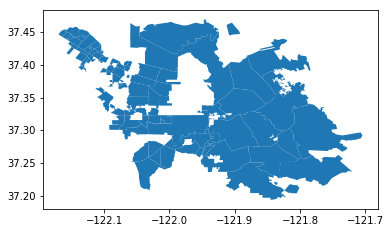

In [6]:
sc_df.plot()

## Assess

In [7]:
#from googleapiclient.discovery import build
#from httplib2 import Http
import gspread
from google.oauth2 import service_account
from google.auth.transport.requests import AuthorizedSession

# The scope to read the spreadsheet
_GS_SCOPE = ['https://www.googleapis.com/auth/spreadsheets.readonly',
            'https://www.googleapis.com/auth/drive']

# The ID and range of the MasterGardener spreadsheet.
_GS_ID = '1pPOuRZ9YsKwXGKgxzSm9tXCR_dgkCY4WNh3rg_cFX08'

service_account_info = json.load(open('Master Gardener-7e906e507d9d.json'))
credentials = service_account.Credentials.from_service_account_info(
    service_account_info,
    scopes=_GS_SCOPE)

if credentials:
    gc = gspread.Client(auth=credentials)
    gc.session = AuthorizedSession(credentials)
    book = gc.open_by_key(_GS_ID)
    print(book.title)
    worksheet_list = book.worksheets()
    for worksheet in worksheet_list:
        print(worksheet)

Santa Clara County Master Gardeners
<Worksheet u'Contacts' id:0>
<Worksheet u'Contact-Neighborhood Mapping' id:1541812186>
<Worksheet u'Zillow Neighborhoods' id:1790253258>
<Worksheet u'Google Neighborhoods' id:1302983281>
<Worksheet u'Nextdoor Neighborhoods' id:284535610>


In [43]:
df_contacts = pd.DataFrame(book.get_worksheet(0).get_all_values())
df_contact_neighborhood = pd.DataFrame(book.get_worksheet(1).get_all_values())
df_zillow_neighborhoods = pd.DataFrame(book.get_worksheet(2).get_all_values())
df_google_neighborhoods = pd.DataFrame(book.get_worksheet(3).get_all_values())

In [44]:
df_contacts.head()

,0,1,2,3,4
0,Name,e-mail,Residence - Nextdoor Neighborhood,Unknown Neighborhood,Notes
1,Anita Rosen,anita@readygo.com,Gemello,FALSE,
2,Ann Ranish,annranish@gmail.com,Starbird,FALSE,
3,Carol Peck,CAnative.carol@gmail.com,Gilroy,FALSE,Northern Gilroy?
4,Don Krafft,dfk@donkrafft.com,Morse Park,FALSE,Sunnyvale


In [45]:
df_contacts.reset_index()
df_contacts.columns = ['Name', 'email', 'Residence - Nextdoor Neighborhood', 'Unknown Neighborhood', 'Notes']

In [46]:
df_contacts = df_contacts[df_contacts['Name'] != 'Name']

In [47]:
df_contacts['Residence - Nextdoor Neighborhood'] = df_contacts['Residence - Nextdoor Neighborhood'].str.title()

In [96]:
df_contacts.head()

,Name,email,Residence - Nextdoor Neighborhood,Unknown Neighborhood,Notes,Similar Google Neighborhood,Similar Zillow Neighborhood,Similar Nextdoor Neighborhood
1,Anita Rosen,anita@readygo.com,Gemello,FALSE,,[],[Gemello Park],[Gemello]
2,Ann Ranish,annranish@gmail.com,Starbird,FALSE,,[],[],[Starbird]
3,Carol Peck,CAnative.carol@gmail.com,Gilroy,FALSE,Northern Gilroy?,[],[],[Old Gilroy]
4,Don Krafft,dfk@donkrafft.com,Morse Park,FALSE,Sunnyvale,[],[Monroe Park],"[Morse Park, Monroe Park, Forest Park]"
5,Jeff Jenks,jenks.jeff@gmail.com,Monta Vista,FALSE,Cupertino,[],"[Monta Vista South, Monta Vista North]","[Monta Vista, Santa Rita, Buena Vista]"


In [49]:
df_contact_neighborhood.head()

,0,1,2
0,Name,Nextdoor Neighborhood,Unknown Neighborhood
1,Allie Judy,San Tomas,FALSE
2,Allie Judy,Newport Apartments,FALSE
3,Allie Judy,Hacienda,FALSE
4,Allie Judy,Pollard Road,FALSE


In [50]:
df_contact_neighborhood.reset_index()
df_contact_neighborhood.columns = ['Name', 'Nextdoor Neighborhood', 'Unknown Neighborhood']

In [51]:
df_contact_neighborhood = df_contact_neighborhood[df_contact_neighborhood['Name'] != 'Name']

In [52]:
df_contact_neighborhood.head()

,Name,Nextdoor Neighborhood,Unknown Neighborhood
1,Allie Judy,San Tomas,FALSE
2,Allie Judy,Newport Apartments,FALSE
3,Allie Judy,Hacienda,FALSE
4,Allie Judy,Pollard Road,FALSE
5,Allie Judy,Los Gatos Woods,FALSE


In [53]:
df_contact_neighborhood['Nextdoor Neighborhood'] = df_contact_neighborhood['Nextdoor Neighborhood'].str.title()

In [54]:
df_contact_neighborhood.head()

,Name,Nextdoor Neighborhood,Unknown Neighborhood
1,Allie Judy,San Tomas,FALSE
2,Allie Judy,Newport Apartments,FALSE
3,Allie Judy,Hacienda,FALSE
4,Allie Judy,Pollard Road,FALSE
5,Allie Judy,Los Gatos Woods,FALSE


In [55]:
df_google_neighborhoods.head()

,0,1,2,3
0,State,County,City,Neighborhood
1,CA,Santa Clara,San Jose,East San Jose
2,CA,Santa Clara,San Jose,Rose Garden
3,CA,Santa Clara,San Jose,Burbank
4,CA,Santa Clara,San Jose,Seven Trees


In [56]:
df_google_neighborhoods.reset_index()
df_google_neighborhoods.columns = ['State', 'County', 'City', 'Neighborhood']

In [57]:
df_google_neighborhoods = df_google_neighborhoods[df_google_neighborhoods['Neighborhood'] != 'Neighborhood']

In [58]:
df_google_neighborhoods.head()

,State,County,City,Neighborhood
1,CA,Santa Clara,San Jose,East San Jose
2,CA,Santa Clara,San Jose,Rose Garden
3,CA,Santa Clara,San Jose,Burbank
4,CA,Santa Clara,San Jose,Seven Trees
5,CA,Santa Clara,San Jose,North San Jose


In [59]:
df_contact_neighborhood['Similar Google Neighborhood'] = 'None'
df_contacts['Similar Google Neighborhood'] = 'None'

In [60]:
neighborhoods = list(df_google_neighborhoods['Neighborhood'])
for index, row in df_contact_neighborhood.iterrows():
    row['Similar Google Neighborhood'] = difflib.get_close_matches(row['Nextdoor Neighborhood'].lower(), neighborhoods)

In [61]:
df_contact_neighborhood.head()

,Name,Nextdoor Neighborhood,Unknown Neighborhood,Similar Google Neighborhood
1,Allie Judy,San Tomas,FALSE,[San Tomas]
2,Allie Judy,Newport Apartments,FALSE,[]
3,Allie Judy,Hacienda,FALSE,[]
4,Allie Judy,Pollard Road,FALSE,[]
5,Allie Judy,Los Gatos Woods,FALSE,[]


In [62]:
for index, row in df_contacts.iterrows():
    row['Similar Google Neighborhood'] = difflib.get_close_matches(row['Residence - Nextdoor Neighborhood'].lower(), neighborhoods)

In [63]:
df_contacts.head()

,Name,email,Residence - Nextdoor Neighborhood,Unknown Neighborhood,Notes,Similar Google Neighborhood
1,Anita Rosen,anita@readygo.com,Gemello,FALSE,,[]
2,Ann Ranish,annranish@gmail.com,Starbird,FALSE,,[]
3,Carol Peck,CAnative.carol@gmail.com,Gilroy,FALSE,Northern Gilroy?,[]
4,Don Krafft,dfk@donkrafft.com,Morse Park,FALSE,Sunnyvale,[]
5,Jeff Jenks,jenks.jeff@gmail.com,Monta Vista,FALSE,Cupertino,[]


In [64]:
df_zillow_neighborhoods.head()

,0,1,2,3,4,5
0,State,County,City,Neighborhood,RegionID,geometry
1,CA,Santa Clara,San Jose,Alviso,8075,POLYGON ((-121.9423569999999 37.46496300000007...
2,CA,Santa Clara,San Jose,Cambrian Park,114074,"POLYGON ((-121.878978755 37.27530488000008, -1..."
3,CA,Santa Clara,Cupertino,Rancho Rinconada,117559,"POLYGON ((-122.00649 37.32295, -122.004603875 ..."
4,CA,Santa Clara,Campbell,San Tomas,117891,POLYGON ((-121.9526834979999 37.27366922400006...


In [65]:
df_zillow_neighborhoods.reset_index()
df_zillow_neighborhoods.columns = ['State', 'County', 'City', 'Neighborhood', 'RegionID', 'Geometry']

In [66]:
df_zillow_neighborhoods = df_zillow_neighborhoods[df_zillow_neighborhoods['Neighborhood'] != 'Neighborhood']

In [67]:
df_zillow_neighborhoods.head()

,State,County,City,Neighborhood,RegionID,Geometry
1,CA,Santa Clara,San Jose,Alviso,8075,POLYGON ((-121.9423569999999 37.46496300000007...
2,CA,Santa Clara,San Jose,Cambrian Park,114074,"POLYGON ((-121.878978755 37.27530488000008, -1..."
3,CA,Santa Clara,Cupertino,Rancho Rinconada,117559,"POLYGON ((-122.00649 37.32295, -122.004603875 ..."
4,CA,Santa Clara,Campbell,San Tomas,117891,POLYGON ((-121.9526834979999 37.27366922400006...
5,CA,Santa Clara,San Jose,Berryessa,113736,POLYGON ((-121.8202519999999 37.43812700000007...


In [68]:
df_contact_neighborhood['Similar Zillow Neighborhood'] = 'None'
df_contacts['Similar Zillow Neighborhood'] = 'None'

In [69]:
neighborhoods = list(df_zillow_neighborhoods['Neighborhood'])
for index, row in df_contact_neighborhood.iterrows():
    row['Similar Zillow Neighborhood'] = difflib.get_close_matches(row['Nextdoor Neighborhood'].lower(), neighborhoods)

In [70]:
df_contact_neighborhood.head()

,Name,Nextdoor Neighborhood,Unknown Neighborhood,Similar Google Neighborhood,Similar Zillow Neighborhood
1,Allie Judy,San Tomas,FALSE,[San Tomas],[San Tomas]
2,Allie Judy,Newport Apartments,FALSE,[],[]
3,Allie Judy,Hacienda,FALSE,[],[]
4,Allie Judy,Pollard Road,FALSE,[],[]
5,Allie Judy,Los Gatos Woods,FALSE,[],[]


In [71]:
for index, row in df_contacts.iterrows():
    row['Similar Zillow Neighborhood'] = difflib.get_close_matches(row['Residence - Nextdoor Neighborhood'].lower(), neighborhoods)

In [72]:
df_contacts.head()

,Name,email,Residence - Nextdoor Neighborhood,Unknown Neighborhood,Notes,Similar Google Neighborhood,Similar Zillow Neighborhood
1,Anita Rosen,anita@readygo.com,Gemello,FALSE,,[],[Gemello Park]
2,Ann Ranish,annranish@gmail.com,Starbird,FALSE,,[],[]
3,Carol Peck,CAnative.carol@gmail.com,Gilroy,FALSE,Northern Gilroy?,[],[]
4,Don Krafft,dfk@donkrafft.com,Morse Park,FALSE,Sunnyvale,[],[Monroe Park]
5,Jeff Jenks,jenks.jeff@gmail.com,Monta Vista,FALSE,Cupertino,[],"[Monta Vista South, Monta Vista North]"


In [73]:
df_contacts.to_csv('mg_contacts_master.csv', index=False)
df_contact_neighborhood.to_csv('mg_contact_neighborhood_master.csv', index=False)

df_google_neighborhoods = pd.DataFrame(index=range(3500), columns = ['State','County', 'City', 'Neighborhood'])
df_loc = 0
df_google_neighborhoods.head(1)

In [74]:
_GM_API_KEY = '####'

cities = ['San Jose', 'Santa Clara', 'Sunnyvale', 'Palo Alto', 'Mountain View',\
          'Cupertino','Milpitas','Los Gatos', 'Gilroy', 'Morgan Hill', 'Campbell','Los Altos'\
          'Saratoga', 'Stanford', 'Los Altos Hills', 'Cambrian Park'\
          'Monte Sereno', 'San Martin', 'East Foothills', 'Alum Rock','Fruitdale', 'Lexington Hills', 'Loyola']

for city in cities:
    cityquery = urllib.parse.quote(city + ' Neighborhoods, California', safe='')
    print(cityquery)
    response = requests.get('https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input=' + cityquery + '&inputtype=textquery&fields=name,id,place_id,plus_code,types,geometry&key=' + _GM_API_KEY)
    resp_json_payload = response.json()
    for k, v in resp_json_payload.items():
        print(k)
        if ((k == 'candidates') & (len(v) > 0)):
            for pair in v:
                if ('neighborhood' == pair['types'][0]) & ('political' == pair['types'][1]):
                    print(pair['name'])
                    df_google_neighborhoods.iloc[df_loc, df_google_neighborhoods.columns.get_loc("State")] = 'CA'
                    df_google_neighborhoods.iloc[df_loc, df_google_neighborhoods.columns.get_loc("County")] = 'Santa Clara'
                    df_google_neighborhoods.iloc[df_loc, df_google_neighborhoods.columns.get_loc("City")] = city
                    df_google_neighborhoods.iloc[df_loc, df_google_neighborhoods.columns.get_loc("Neighborhood")] = pair['name']
                    df_loc += 1

df_google_neighborhoods.dropna(axis = 0, inplace=True)
df_google_neighborhoods.tail()
print(df_loc)

In [75]:
df_google_neighborhoods.head(1)

,State,County,City,Neighborhood
1,CA,Santa Clara,San Jose,East San Jose


In [76]:
df_google_neighborhoods.to_csv('mg_google_neighborhoods_master.csv', index=False)

## Scraping nextdoor 

In [77]:
state = 'CA'
state_url = 'https://nextdoor.com/find-neighborhood/' + state + '/'

In [78]:
from requests import get
response = requests.get(state_url)
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [79]:
hood_city_group = html_soup.find_all('div', class_ = 'hood_group')
print(type(hood_city_group))
print(len(hood_city_group))

<class 'bs4.element.ResultSet'>
24


In [80]:
df_cities = pd.DataFrame(index=range(5000), columns = ['State', 'City', 'Link'])
df_loc = 0
df_cities.head(1)

,State,City,Link
0,NaN,NaN,NaN


In [81]:
for div in hood_city_group:
    city_links = div.findAll('a')
    for a in city_links:
        df_cities.iloc[df_loc, df_cities.columns.get_loc("State")] = 'CA'
        df_cities.iloc[df_loc, df_cities.columns.get_loc("City")] = a.string
        df_cities.iloc[df_loc, df_cities.columns.get_loc("Link")] = a['href'].strip()
        df_loc += 1

df_cities.dropna(axis = 0, inplace=True)
print(df_loc)

1164


In [82]:
df_cities.reindex(columns=['State','County','City', 'Link'])
df_cities.head(1)

,State,City,Link
0,CA,Acampo,https://nextdoor.com/city/acampo--ca/


In [83]:
df_cities.to_csv('mg_nextdoor_california_cities.csv', index=False)

In [84]:
cities = ['San Jose','Santa Clara','Sunnyvale', 'Palo Alto','Mountain View',\
          'Cupertino','Milpitas','Los Gatos', 'Gilroy', 'Morgan Hill', 'Campbell',\
          'Los Altos','Saratoga', 'Stanford', 'Los Altos Hills',\
          'San Martin']

In [152]:
df_nextdoor_neighborhoods = pd.DataFrame(index=range(7000), columns = ['State', 'County', 'City', 'Neighborhood', 'Link'])
df_loc = 0
df_nextdoor_neighborhoods.head(1)

,State,County,City,Neighborhood,Link
0,NaN,NaN,NaN,NaN,NaN


In [153]:
for city in cities:
    print(city)
    city_lookup = df_cities[df_cities['City'] == city]["Link"].values[0]
    print(city_lookup)
    response = requests.get(city_lookup)
    responseTxt = response.text.encode('UTF-8')
    html_soup = BeautifulSoup(responseTxt, 'html.parser')
    type(html_soup) 
    hood_neighborhood_group = html_soup.find_all('div', class_ = 'hood_group')
    print(type(hood_neighborhood_group))
    print(len(hood_neighborhood_group))
   
    for div in hood_neighborhood_group:
        neighborhood_links = div.findAll('a')
        for a in neighborhood_links:
            print(city + " " + a.string + " " +  a['href'])
            df_nextdoor_neighborhoods.iloc[df_loc, df_nextdoor_neighborhoods.columns.get_loc("State")] = 'CA'
            df_nextdoor_neighborhoods.iloc[df_loc, df_nextdoor_neighborhoods.columns.get_loc("County")] = 'Santa Clara'
            df_nextdoor_neighborhoods.iloc[df_loc, df_nextdoor_neighborhoods.columns.get_loc("City")] = city
            df_nextdoor_neighborhoods.iloc[df_loc, df_nextdoor_neighborhoods.columns.get_loc("Neighborhood")] = str(a.string.encode('UTF-8'))
            df_nextdoor_neighborhoods.iloc[df_loc, df_nextdoor_neighborhoods.columns.get_loc("Link")] = str(a['href'].strip())
            df_loc += 1

df_nextdoor_neighborhoods.dropna(axis = 0, inplace=True)
print(df_loc)

San Jose
https://nextdoor.com/city/san-jose--ca/
<class 'bs4.element.ResultSet'>
23
San Jose Albanese Circle https://nextdoor.com/neighborhood/albanesecircle--san-jose--ca/
San Jose Almaden https://nextdoor.com/neighborhood/almadenca--san-jose--ca/
San Jose Alvin/Burdette https://nextdoor.com/neighborhood/7alvinburdette--san-jose--ca/
San Jose Alviso https://nextdoor.com/neighborhood/4alviso--san-jose--ca/
San Jose Anne Darling - Little Portugal North https://nextdoor.com/neighborhood/3littleportugalnorth--san-jose--ca/
San Jose Apts https://nextdoor.com/neighborhood/aptsca--san-jose--ca/
San Jose Arbuckle https://nextdoor.com/neighborhood/5arbuckle--san-jose--ca/
San Jose Archer - North 4th https://nextdoor.com/neighborhood/archer4th--san-jose--ca/
San Jose Ascent https://nextdoor.com/neighborhood/ascentca--san-jose--ca/
San Jose Autumnvale https://nextdoor.com/neighborhood/4autumnvale--san-jose--ca/
San Jose Avana Skyway https://nextdoor.com/neighborhood/avanaskyway--san-jose--ca/
Sa

San Jose Doerr https://nextdoor.com/neighborhood/9doerr--san-jose--ca/
San Jose Dorsa https://nextdoor.com/neighborhood/5dorsa--san-jose--ca/
San Jose Downing - Whitethorne https://nextdoor.com/neighborhood/6downingwhitethorne--san-jose--ca/
San Jose Downtown https://nextdoor.com/neighborhood/downtownsanjoseca--san-jose--ca/
San Jose Dry Creek https://nextdoor.com/neighborhood/9drycreekca--san-jose--ca/
San Jose East Ct West Ct https://nextdoor.com/neighborhood/3eastctwestct--san-jose--ca/
San Jose Easterbrook https://nextdoor.com/neighborhood/1easterbrook--san-jose--ca/
San Jose East Foothills https://nextdoor.com/neighborhood/5eastfoothillsca--san-jose--ca/
San Jose EDD America’s Job Center https://nextdoor.com/neighborhood/eddamericasjobcenter--san-jose--ca/
San Jose Eden https://nextdoor.com/neighborhood/1eden--san-jose--ca/
San Jose Edge https://nextdoor.com/neighborhood/8edge--san-jose--ca/
San Jose Ellis-Louise https://nextdoor.com/neighborhood/6ellis-louise--san-jose--ca/
San J

San Jose Norwood https://nextdoor.com/neighborhood/8norwoodsanjose--san-jose--ca/
San Jose N White Rd https://nextdoor.com/neighborhood/nwhiterd--san-jose--ca/
San Jose Oak Canyon https://nextdoor.com/neighborhood/10oakcanyon--san-jose--ca/
San Jose Oak Grove https://nextdoor.com/neighborhood/2oakgrovesanjose--san-jose--ca/
San Jose Oak Hill https://nextdoor.com/neighborhood/oakhillca--san-jose--ca/
San Jose Oakland Road https://nextdoor.com/neighborhood/oaklandroad--san-jose--ca/
San Jose Oakwood https://nextdoor.com/neighborhood/oakwoodsanjose--san-jose--ca/
San Jose Ocala https://nextdoor.com/neighborhood/8ocala--san-jose--ca/
San Jose Ohlone https://nextdoor.com/neighborhood/4ohlone--san-jose--ca/
San Jose Old Port https://nextdoor.com/neighborhood/4oldport--san-jose--ca/
San Jose Olinder https://nextdoor.com/neighborhood/3olinder--san-jose--ca/
San Jose Onyx https://nextdoor.com/neighborhood/onyxsjca--san-jose--ca/
San Jose Orchard Park https://nextdoor.com/neighborhood/orchardpar

San Jose Upper Sierra https://nextdoor.com/neighborhood/4uppersierra--san-jose--ca/
San Jose Valley  View / Reed https://nextdoor.com/neighborhood/9valleyviewreed--san-jose--ca/
San Jose Vendome - Civic Center https://nextdoor.com/neighborhood/3vendomesj--san-jose--ca/
San Jose Villa Cortona https://nextdoor.com/neighborhood/villacortonasj--san-jose--ca/
San Jose Villas of Mabury https://nextdoor.com/neighborhood/villasofmaburyca--san-jose--ca/
San Jose Villa Teresa Park https://nextdoor.com/neighborhood/villateresapark--san-jose--ca/
San Jose Villa Valencia https://nextdoor.com/neighborhood/villavalencia--san-jose--ca/
San Jose Vinci South https://nextdoor.com/neighborhood/4vincisouth--san-jose--ca/
San Jose Vineyard Park https://nextdoor.com/neighborhood/8vineyardpark--san-jose--ca/
San Jose Vista  Park https://nextdoor.com/neighborhood/10vistapark--san-jose--ca/
San Jose Vistapark-Martial Cottle https://nextdoor.com/neighborhood/vistaparkmartialcottle--san-jose--ca/
San Jose Vivient

<class 'bs4.element.ResultSet'>
19
Sunnyvale 37 Degrees North https://nextdoor.com/neighborhood/37degreesnorth--sunnyvale--ca/
Sunnyvale Adobe Wells MHP https://nextdoor.com/neighborhood/adobewellsmhp--sunnyvale--ca/
Sunnyvale Avalon Silicon Valley https://nextdoor.com/neighborhood/avalonsiliconvalley--sunnyvale--ca/
Sunnyvale Belleville https://nextdoor.com/neighborhood/belleville--sunnyvale--ca/
Sunnyvale Bernardo Iowa https://nextdoor.com/neighborhood/bernardoiowa--sunnyvale--ca/
Sunnyvale Bobwhite and Bobolink https://nextdoor.com/neighborhood/bobwhiteandbobolink--sunnyvale--ca/
Sunnyvale Casa Blanca Townhomes https://nextdoor.com/neighborhood/casablancatownhomes--sunnyvale--ca/
Sunnyvale Casa De Amigos https://nextdoor.com/neighborhood/casadeamigos--sunnyvale--ca/
Sunnyvale Cedarwood https://nextdoor.com/neighborhood/cedarwoodsunnyvale--sunnyvale--ca/
Sunnyvale Cherry Chase https://nextdoor.com/neighborhood/cherrychase--sunnyvale--ca/
Sunnyvale Cherry Hill https://nextdoor.com/nei

<class 'bs4.element.ResultSet'>
17
Mountain View Americana https://nextdoor.com/neighborhood/americanaca--mountain-view--ca/
Mountain View Birch Creek https://nextdoor.com/neighborhood/birchcreek--mountain-view--ca/
Mountain View Blossom Valley https://nextdoor.com/neighborhood/blossomvalley--mountain-view--ca/
Mountain View Carmel The Village https://nextdoor.com/neighborhood/carmelthevillage--mountain-view--ca/
Mountain View Cuernavaca https://nextdoor.com/neighborhood/cuernavacaca--mountain-view--ca/
Mountain View Cuesta Park https://nextdoor.com/neighborhood/cuestapark--mountain-view--ca/
Mountain View Del Medio https://nextdoor.com/neighborhood/delmedio--mountain-view--ca/
Mountain View Ellis St https://nextdoor.com/neighborhood/ellisst--mountain-view--ca/
Mountain View Farley https://nextdoor.com/neighborhood/farleymv--mountain-view--ca/
Mountain View Gemello https://nextdoor.com/neighborhood/gemello--mountain-view--ca/
Mountain View Hidden Gardens https://nextdoor.com/neighborho

Milpitas Pace https://nextdoor.com/neighborhood/pacemil--milpitas--ca/
Milpitas Parc Metropolitan https://nextdoor.com/neighborhood/parcmetropolitan--milpitas--ca/
Milpitas Parc Place https://nextdoor.com/neighborhood/parcplace--milpitas--ca/
Milpitas Park Victoria https://nextdoor.com/neighborhood/parkvictoria--milpitas--ca/
Milpitas Piedmont https://nextdoor.com/neighborhood/piedmontca--milpitas--ca/
Milpitas Poppy Lane Townhouses https://nextdoor.com/neighborhood/poppylanetownhouses--milpitas--ca/
Milpitas Reflections And Images https://nextdoor.com/neighborhood/reflectionsandimages--milpitas--ca/
Milpitas Sepulveda/Pedro Loop https://nextdoor.com/neighborhood/sepulveda-pedro--milpitas--ca/
Milpitas Shapell Hillcrest https://nextdoor.com/neighborhood/shapellhillcrest--milpitas--ca/
Milpitas Sinnott Loop https://nextdoor.com/neighborhood/sinnottloop--milpitas--ca/
Milpitas Snell https://nextdoor.com/neighborhood/snellmilpitas--milpitas--ca/
Milpitas Spring Valley Ln https://nextdoor.

<class 'bs4.element.ResultSet'>
12
Morgan Hill Barrett https://nextdoor.com/neighborhood/barrettca--morgan-hill--ca/
Morgan Hill Butterfield Station https://nextdoor.com/neighborhood/butterfieldstation--morgan-hill--ca/
Morgan Hill Capriano https://nextdoor.com/neighborhood/capriano--morgan-hill--ca/
Morgan Hill Carriage Dr https://nextdoor.com/neighborhood/carriagedrca--morgan-hill--ca/
Morgan Hill Coyote Creek https://nextdoor.com/neighborhood/coyote-creek--morgan-hill--ca/
Morgan Hill El Toro https://nextdoor.com/neighborhood/eltoro--morgan-hill--ca/
Morgan Hill Holiday Lake https://nextdoor.com/neighborhood/holidaylake--morgan-hill--ca/
Morgan Hill Jackson Meadows https://nextdoor.com/neighborhood/jackson-meadows--morgan-hill--ca/
Morgan Hill Jackson Oaks https://nextdoor.com/neighborhood/jacksonoaksca--morgan-hill--ca/
Morgan Hill Llagas https://nextdoor.com/neighborhood/llagas--morgan-hill--ca/
Morgan Hill Mirasol https://nextdoor.com/neighborhood/mirasolmh--morgan-hill--ca/
Morg

<class 'bs4.element.ResultSet'>
1
Stanford Stanford Campus https://nextdoor.com/neighborhood/stanfordcampus--stanford--ca/
Los Altos Hills
https://nextdoor.com/city/los-altos-hills--ca/
<class 'bs4.element.ResultSet'>
9
Los Altos Hills Aric Weston-Zone 32 https://nextdoor.com/neighborhood/aricwestonzone32--los-altos-hills--ca/
Los Altos Hills Border Hill Rd-Zone 45 https://nextdoor.com/neighborhood/lahcfdz45--los-altos-hills--ca/
Los Altos Hills Country Club-Zone 36 https://nextdoor.com/neighborhood/lahcfdz36--los-altos-hills--ca/
Los Altos Hills Country Club-Zone 39 https://nextdoor.com/neighborhood/lahcfdz39--los-altos-hills--ca/
Los Altos Hills Country Club-Zone 42 https://nextdoor.com/neighborhood/lahcfdz42--los-altos-hills--ca/
Los Altos Hills LAH Saddle Mountain-Zone 2 https://nextdoor.com/neighborhood/lahsaddlemountainz2--los-altos-hills--ca/
Los Altos Hills Los Altos Hills Town Hall Circle https://nextdoor.com/neighborhood/losaltoshillstownhallcircle--los-altos-hills--ca/
Los A

In [154]:
df_nextdoor_neighborhoods.head(3)

,State,County,City,Neighborhood,Link
0,CA,Santa Clara,San Jose,Albanese Circle,https://nextdoor.com/neighborhood/albanesecirc...
1,CA,Santa Clara,San Jose,Almaden,https://nextdoor.com/neighborhood/almadenca--s...
2,CA,Santa Clara,San Jose,Alvin/Burdette,https://nextdoor.com/neighborhood/7alvinburdet...


In [155]:
df_nextdoor_neighborhoods.to_csv('mg_nextdoor_neighborhoods_master.csv', index=False)

In [156]:
df_contact_neighborhood['Similar Nextdoor Neighborhood'] = 'None'
df_contacts['Similar Nextdoor Neighborhood'] = 'None'

In [157]:
neighborhoods = list(df_nextdoor_neighborhoods['Neighborhood'])
for index, row in df_contact_neighborhood.iterrows():
    row['Similar Nextdoor Neighborhood'] = difflib.get_close_matches(row['Nextdoor Neighborhood'].lower(), neighborhoods)

In [158]:
for index, row in df_contacts.iterrows():
    row['Similar Nextdoor Neighborhood'] = difflib.get_close_matches(row['Residence - Nextdoor Neighborhood'].lower(), neighborhoods)

In [159]:
df_contacts.head(1)

,Name,email,Residence - Nextdoor Neighborhood,Unknown Neighborhood,Notes,Similar Google Neighborhood,Similar Zillow Neighborhood,Similar Nextdoor Neighborhood
1,Anita Rosen,anita@readygo.com,Gemello,FALSE,,[],[Gemello Park],[Gemello]


In [160]:
df_contact_neighborhood.head(1)

,Name,Nextdoor Neighborhood,Unknown Neighborhood,Similar Google Neighborhood,Similar Zillow Neighborhood,Similar Nextdoor Neighborhood
1,Allie Judy,San Tomas,FALSE,[San Tomas],[San Tomas],[San Tomas]


In [161]:
df_contact_neighborhood['Nextdoor Neighborhood'].nunique()

320

In [162]:
df_contact_neighborhood['Nextdoor Neighborhood'].value_counts()

Los Gatos Woods             3
Upper Sierra                3
Saratoga Village            2
Village Green               2
Rinconada Hills             2
Knights Bridge              2
Cuesta Park                 2
Cumberland South            2
Coyote Creek                2
Boulder                     2
Piedmont                    2
Varsity Park                2
Penitencia                  2
West Los Gatos              2
Remington                   2
Sunshine                    2
Rinconada                   2
Old Mountain View           2
San Tomas                   2
Ruskin                      2
Westgate Village            2
Sobrato                     2
Sunnyvale                   2
Lowlanders                  2
Summerdale                  2
Pinnacle                    2
Mccollam                    2
Woodland Acres              2
Somerset Knolls             2
Pollard Road                2
                           ..
Reamwood Statin             1
Morrill                     1
Silver Oak

In [163]:
df_contacts.to_csv('mg_contacts_master.csv', index=False)
df_contact_neighborhood.to_csv('mg_contact_neighborhood_master.csv', index=False)

df_nextdoor_neighborhoods['Similar Google Neighborhood'] = 'None'
df_nextdoor_neighborhoods['Google Place ID'] = 'None'

import six.moves.urllib as urllib

for index, row in df_nextdoor_neighborhoods.iterrows():
    neighborhoodquery = urllib.parse.quote(row["Neighborhood"] + ', ' +  row["City"] + ', ' +  row["State"], safe='')
    print(neighborhoodquery)
    response = requests.get('https://maps.googleapis.com/maps/api/place/findplacefromtext/json?input=' + neighborhoodquery + '&inputtype=textquery&fields=name,id,place_id,plus_code,types,geometry&key=' + _GM_API_KEY)
    resp_json_payload = response.json()
    print(resp_json_payload)                                           
    for k, v in resp_json_payload.items():
        print(k)
        if ((k == 'candidates') & (len(v) > 0)):
            for pair in v:
                if (('neighborhood' == pair['types'][0]) or ('locality' in pair['types'][0])):
                    if ('political' == pair['types'][1]):
                        print(pair['name'])
                        print(pair['place_id'])
                        row["Similar Google Neighborhood"] = pair['name']
                        row["Google Place ID"] = pair['place_id']

In [187]:
df_nextdoor_neighborhoods.to_csv('mg_nextdoor_master.csv', index=False)
df_nextdoor_neighborhoods.head(3)

,State,County,City,Neighborhood,Link,Similar Google Neighborhood,Google Place ID
0,CA,Santa Clara,San Jose,Albanese Circle,https://nextdoor.com/neighborhood/albanesecirc...,None,None
1,CA,Santa Clara,San Jose,Almaden,https://nextdoor.com/neighborhood/almadenca--s...,Almaden,ChIJ8RtyWWkwjoARKOALmJ4lSgU
2,CA,Santa Clara,San Jose,Alvin/Burdette,https://nextdoor.com/neighborhood/7alvinburdet...,Alvin - Burdette,ChIJn5Y5-ZUyjoARiM0tE09NqXY
3,CA,Santa Clara,San Jose,Alviso,https://nextdoor.com/neighborhood/4alviso--san...,Alviso,ChIJ6ZeMLxTIj4ARVMglvFjq5HY
4,CA,Santa Clara,San Jose,Anne Darling - Little Portugal North,https://nextdoor.com/neighborhood/3littleportu...,None,None
5,CA,Santa Clara,San Jose,Apts,https://nextdoor.com/neighborhood/aptsca--san-...,None,None
6,CA,Santa Clara,San Jose,Arbuckle,https://nextdoor.com/neighborhood/5arbuckle--s...,None,None
7,CA,Santa Clara,San Jose,Archer - North 4th,https://nextdoor.com/neighborhood/archer4th--s...,None,None
8,CA,Santa Clara,San Jose,Ascent,https://nextdoor.com/neighborhood/ascentca--sa...,None,None
9,CA,Santa Clara,San Jose,Autumnvale,https://nextdoor.com/neighborhood/4autumnvale-...,None,None


## Parsing geoJSON

In [112]:
import subprocess
neighborhood_json = json.loads(neighborhoodGeometries)

with open('data.geojson', 'w') as f:
    geojson.dump(neighborhood_json, f)

args = ['ogr2ogr', '-f', 'ESRI Shapefile', 'destination_data.shp', 'data.geojson']
subprocess.Popen(args)

In [235]:
df_nextdoor_neighborhoods.drop(['hood_name', 'hood_id', 'geometry'], axis=1, inplace=True)

In [229]:
df_nextdoor_neighborhoods["Hood Name"] = 'None'
df_nextdoor_neighborhoods["Hood ID"] = 'None'
df_nextdoor_neighborhoods["Geometry"] = 'None'
df_nextdoor_neighborhoods["Interests"] = 'None'

In [230]:
for index, row in df_nextdoor_neighborhoods.iterrows():
    neighborhood_lookup = row["Link"]
    print(neighborhood_lookup)
    response = requests.get(neighborhood_lookup)
    responseTxt = response.text.encode('UTF-8')
    html_soup = BeautifulSoup(responseTxt, 'html.parser')
     
    try:
        scripts = html_soup.findAll('script')
        neighborhood_info = scripts[5].string.strip()
        neighborhood_info = neighborhood_info[neighborhood_info.index('['):-1]

        neighborhoodGeometries = neighborhood_info[neighborhood_info.index('neighborhoodGeometriesJSON: '): neighborhood_info.index('neighborhoodMapOptions:{')]
        neighborhoodGeometries = neighborhoodGeometries.lstrip()
        neighborhoodGeometries = neighborhoodGeometries.rstrip()
        begIndex = len('neighborhoodGeometriesJSON: ')
        neighborhoodGeometries = neighborhoodGeometries[begIndex: -1]
        neighborhood_json = json.loads(neighborhoodGeometries)

        feature = neighborhood_json["features"][0]
        geometry = str(feature["geometry"]).encode('UTF-8')
        print(geometry)
        row["Geometry"] = geometry  

        props = feature["properties"]
        print("Name %s, id %s \n" % (props["hood_name"], props["hood_id"]))   

        row["Hood Name"] = props["hood_name"].encode('UTF-8')
        row["Hood ID"] = props["hood_id"]                                        

        try:
            begInterestIndex = neighborhood_info.index('interests: [')
            endInterestIndex = neighborhood_info.index('iosUrl: "https://')
            if ((begInterestIndex > 0) and (endInterestIndex > 0)):
                interests = neighborhood_info[begInterestIndex: endInterestIndex]
                interests = interests[interests.index('[') +1: interests.index(']')]
                print("Interests: %s\n" % interests.encode('UTF-8'))
                row["Interests"] = interests 
        except:
            print("No interests found for: %s", row["Hood Name"])
    except:
        print("Error parsing")

https://nextdoor.com/neighborhood/albanesecircle--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.846314, 37.308618], [-121.844878, 37.309554], [-121.844877, 37.309554], [-121.84479299999998, 37.30954], [-121.84479199999998, 37.30954], [-121.84479199999998, 37.309539], [-121.844584, 37.309345], [-121.844584, 37.309344], [-121.84456599999999, 37.309275], [-121.84456499999999, 37.309273], [-121.84456399999999, 37.309272], [-121.84452699999997, 37.309219], [-121.84452499999998, 37.309217], [-121.84452399999998, 37.309216], [-121.84441099999998, 37.30915], [-121.84440999999998, 37.30915], [-121.84402, 37.308828], [-121.844019, 37.308827], [-121.843707, 37.308643], [-121.843706, 37.308642], [-121.84335799999997, 37.308489], [-121.84335699999997, 37.308488], [-121.84287599999999, 37.308329], [-121.84287499999999, 37.308329], [-121.84287499999999, 37.308328], [-121.84278, 37.308253], [-121.84277800000001, 37.308252], [-121.84277600000001, 37.308251], [-121.84277400000002, 37

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.86862286784344, 37.35691202205406], [-121.86722189299451, 37.35784932241729], [-121.86706546312848, 37.35801910659143], [-121.86681766837069, 37.358388077002786], [-121.86665570430142, 37.3588764368943], [-121.86649374023227, 37.359245406842824], [-121.86621375896641, 37.35946940400584], [-121.86441920362046, 37.36037997405059], [-121.86382893840505, 37.360425034821695], [-121.8633680685906, 37.360634217293644], [-121.85555251912047, 37.352792794254924], [-121.86163410406323, 37.349914783833896], [-121.86296177462225, 37.35138269054655], [-121.86894598308373, 37.35672602033082], [-121.86862286784344, 37.35691202205406], [-121.86862286784344, 37.35691202205406]]]]}
Name Anne Darling - Little Portugal North, id 169885 

Interests: "Dogs", "Cooking", "Hiking & Trails", "Camping", "Dancing", "Gardening & Landscape", "BBQ & Grilling", "Baking", "Home Improvement & DIY", "Walking"

https://nextdoor.com/neighborhood/aptsca--san-jose--ca/
{u'

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.797677, 37.245348], [-121.797471, 37.245159], [-121.797298, 37.24488], [-121.79708, 37.244263], [-121.796869, 37.243991], [-121.796615, 37.243813], [-121.796151, 37.243724], [-121.795434, 37.243776], [-121.794939, 37.243633], [-121.794678, 37.243176], [-121.794621, 37.242641], [-121.79465, 37.242192], [-121.794529, 37.241388], [-121.79416, 37.240658], [-121.79799, 37.241615], [-121.8001055661316, 37.24227994983098], [-121.7996908761501, 37.24334116479541], [-121.7996069127741, 37.24332514904167], [-121.7992118131523, 37.24421446677609], [-121.7991119940414, 37.24586709335981], [-121.798966, 37.24585], [-121.798559, 37.245805], [-121.798199, 37.245669], [-121.797677, 37.245348]]]]}
Name AvenueOne, id 311999 

Interests: "Hiking & Trails", "Home Improvement & DIY", "Walking", "Cooking", "Volunteering", "Yoga", "Biking & Cycling", "Cards & Board Games", "Travel", "Family Activities"

https://nextdoor.com/neighborhood/1bakerwest--san-jose

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.93619699999999, 37.293416], [-121.93558100000001, 37.294471], [-121.93558100000001, 37.294472], [-121.93388500000003, 37.295991], [-121.93388400000003, 37.295991], [-121.93251499999997, 37.296983], [-121.93222800000001, 37.297181], [-121.93134199999997, 37.297328], [-121.93134099999997, 37.297329], [-121.931036, 37.297358], [-121.93103500000001, 37.297358], [-121.930995, 37.297338], [-121.930993, 37.297338], [-121.93099000000001, 37.297337], [-121.93087400000002, 37.297336], [-121.93087300000002, 37.297336], [-121.930365, 37.297412], [-121.930364, 37.297412], [-121.93018899999998, 37.297387], [-121.93018699999999, 37.297387], [-121.92977100000002, 37.297414], [-121.92977000000002, 37.297414], [-121.92967699999997, 37.297404], [-121.92967499999997, 37.297404], [-121.92967299999998, 37.297404], [-121.92967199999998, 37.297404], [-121.92966999999999, 37.297405], [-121.92951099999999, 37.297511], [-121.92951, 37.297511], [-121.92938400000

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.78799441170895, 37.2948645931339], [-121.78766741594654, 37.29485756675054], [-121.7874085815804, 37.29486615871591], [-121.7871132031496, 37.29492044205945], [-121.78679776581379, 37.29501085419026], [-121.7864940824029, 37.29511171039162], [-121.78618716489927, 37.295267002287666], [-121.78590945371332, 37.29544647352236], [-121.78434414002885, 37.29663576125688], [-121.7841093843366, 37.29683307071471], [-121.78380406689291, 37.29701593457312], [-121.783451322845, 37.29718605803852], [-121.78307551114813, 37.297320115677394], [-121.78271750701288, 37.297429767816006], [-121.78236065037368, 37.29749885674433], [-121.78203422763966, 37.297551933304156], [-121.7815313967846, 37.297591086102386], [-121.78108288621337, 37.29755470794811], [-121.78069075428584, 37.29752853085121], [-121.77761799587228, 37.29718179682881], [-121.77725358576765, 37.297182352529546], [-121.77683336399457, 37.29720471249769], [-121.77588856119121, 37.2973224

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.85501736230736, 37.31936136642191], [-121.8538053597162, 37.31950506041283], [-121.8534020583295, 37.31941263244803], [-121.85255799327422, 37.318854472378696], [-121.85436576608043, 37.31765371601538], [-121.8560405798383, 37.31925615486813], [-121.85699119716219, 37.31933982380664], [-121.85612318969356, 37.31972356665316], [-121.85563069148702, 37.31984280818099], [-121.85501736230736, 37.31936136642191]]]]}
Name Bevin  Brook, id 170238 

Interests: "Walking", "Dogs", "Hiking & Trails", "Books", "Cooking", "Seeing Live Music", "Cards & Board Games", "Gardening & Landscape", "Home Improvement & DIY", "Yoga"

https://nextdoor.com/neighborhood/blackfordnacsanjose--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.97020989972316, 37.31439112193468], [-121.97022039852737, 37.316293952360326], [-121.96489706630052, 37.31645282377759], [-121.96400474336616, 37.31647943928703], [-121.96398747606969, 37.31582817346388], [-12

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.866579, 37.254364], [-121.86772221230319, 37.25153592000014], [-121.86939999999998, 37.251699], [-121.86924499999998, 37.253097], [-121.86931700000002, 37.253708], [-121.86914300000001, 37.254761], [-121.866579, 37.254364]]]]}
Name Blossom  River, id 170077 

Interests: "Hiking & Trails", "Volunteering", "Walking", "Camping", "Parenting School-Age Kids", "Animal Adoption", "Bowling", "Cards & Board Games", "Cooking", "Dancing"

https://nextdoor.com/neighborhood/blossomtrails--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.8306737222681, 37.241340807913026], [-121.83062402198095, 37.23880390126846], [-121.831622241775, 37.23879102907368], [-121.831630605751, 37.23919112472182], [-121.83205589455429, 37.23920326121509], [-121.83260499601249, 37.23931803101514], [-121.83256091961039, 37.239491571356545], [-121.83262907608389, 37.24129300047115], [-121.8306737222681, 37.241340807913026]]]]}
Name Blossom Trails, id 19195

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.89908765813743, 37.256398179071795], [-121.89864159476082, 37.25582806448849], [-121.89770876308813, 37.2546291583705], [-121.89653430224269, 37.25308052166873], [-121.8961504780753, 37.25234959856004], [-121.89586053608224, 37.251651614253134], [-121.89545987467858, 37.25070689561024], [-121.8992006258054, 37.25068694931961], [-121.91049984193614, 37.25060722230429], [-121.910814481702, 37.25107119451062], [-121.9111474270768, 37.251374580880466], [-121.90969836427621, 37.252852228451665], [-121.90870710899588, 37.25353765622834], [-121.90724378492911, 37.25439387150157], [-121.90648352043479, 37.25542248803366], [-121.90566208134146, 37.25659751913856], [-121.90506732855704, 37.25744508762339], [-121.90413942189252, 37.25832684778116], [-121.9030490496076, 37.25914763601772], [-121.90099162025558, 37.2597135706551], [-121.900669958315, 37.25892902756463], [-121.9004688942095, 37.25853888775677], [-121.89908765813743, 37.256398179071

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.771387388529, 37.29937708422607], [-121.7733370762157, 37.29810341692879], [-121.7738271803465, 37.29782980418963], [-121.7745747765426, 37.2975647252366], [-121.7762416303118, 37.29727353969779], [-121.7768522709652, 37.29719704133164], [-121.7773989901033, 37.29717586177136], [-121.7777206294346, 37.29718660905153], [-121.7783963203558, 37.2972656348798], [-121.7824353106423, 37.29984607373535], [-121.7753276027547, 37.30092101738262], [-121.7718355126194, 37.3016119021723], [-121.7703716482533, 37.30184689753329], [-121.769787548444, 37.29993122579285], [-121.771387388529, 37.29937708422607]]]]}
Name Buena  Park, id 170242 

Interests: "Walking", "Hiking & Trails", "Home Improvement & DIY", "Cooking", "Seeing Live Music", "Baking", "Dogs", "Volunteering", "Books", "Family Activities"

https://nextdoor.com/neighborhood/buenavistasanjose--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.92383676154509, 37.32343122405

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.7937431722562, 37.24026368976002], [-121.7937250239421, 37.236607009461075], [-121.79460323745451, 37.236829218554135], [-121.79548145096709, 37.2369318439039], [-121.79835367694227, 37.23691501140688], [-121.79916286430534, 37.23700092957023], [-121.80385058340323, 37.23699355626096], [-121.80387832543806, 37.238906970439395], [-121.80396729830795, 37.242895768254684], [-121.80249231070627, 37.24257050498105], [-121.7937431722562, 37.24026368976002], [-121.7937431722562, 37.24026368976002]]]]}
Name California Grove, id 171123 

Interests: "Hiking & Trails", "Cooking", "Home Improvement & DIY", "Volunteering", "Books", "Gardening & Landscape", "Family Activities", "Seeing Live Music", "Walking", "Dancing"

https://nextdoor.com/neighborhood/4californiaimpressions--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.96096399999999, 37.413163], [-121.96112499999998, 37.413275], [-121.96124299999997, 37.41342], [-121.9613289

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.88022629675356, 37.24292721719025], [-121.87876405279621, 37.24395407970102], [-121.87703358793732, 37.24440015540205], [-121.874736055894, 37.24451216198377], [-121.87494568493753, 37.24264284901987], [-121.87490029575446, 37.2418021273545], [-121.87472739745806, 37.24092908060488], [-121.87422092044801, 37.23977774833407], [-121.87382173179867, 37.23867764724324], [-121.87313064286059, 37.23627239563784], [-121.87456619368953, 37.23580678344439], [-121.87489667440434, 37.235640132049234], [-121.87513500194234, 37.23549307666657], [-121.87534114297216, 37.23529476996597], [-121.87553655516581, 37.235062295280215], [-121.87566759434327, 37.23482127798315], [-121.87575801132107, 37.234441744404045], [-121.87576259761045, 37.23408783485337], [-121.8758235102892, 37.233738194650144], [-121.87602389783655, 37.23340563693849], [-121.87632084490849, 37.23309016194423], [-121.87652123245596, 37.23276614350268], [-121.87663752842968, 37.23234

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.90777631245152, 37.400295425018946], [-121.90777607487274, 37.40029586771069], [-121.9077755856672, 37.4002959821554], [-121.90775603981731, 37.40029841342286], [-121.90775399808913, 37.40029888881512], [-121.90775210033391, 37.400299779419896], [-121.90775042995136, 37.4003010460982], [-121.907749060349, 37.40030263318394], [-121.90774805171608, 37.40030447093022], [-121.90716673832215, 37.40169120662467], [-121.90716629303223, 37.40169251638248], [-121.90711803548307, 37.40187502614518], [-121.90711781181015, 37.40187568332356], [-121.90669387265064, 37.402885097751756], [-121.90669366584241, 37.402885530685644], [-121.90663209749816, 37.40299994725373], [-121.90663185314126, 37.403000313988045], [-121.90663141714248, 37.40300024988274], [-121.9058175834484, 37.40280103017755], [-121.90581714913394, 37.40280087579096], [-121.90581723678912, 37.40280042326384], [-121.90594844631026, 37.402365187177566], [-121.90594881279598, 37.40236

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.79823946817442, 37.32865328612635], [-121.79027289626703, 37.330256128285704], [-121.78285558743994, 37.33174514613381], [-121.78232408342961, 37.330057654328556], [-121.78227085048366, 37.329681920995796], [-121.78222397900919, 37.32940788937717], [-121.78222002287896, 37.32898029504663], [-121.7821682304866, 37.32497304264087], [-121.79589065620166, 37.32476467196825], [-121.79648733450938, 37.324819524439924], [-121.79695526678444, 37.32492556694148], [-121.79823946817442, 37.32865328612635], [-121.79823946817442, 37.32865328612635], [-121.79823946817442, 37.32865328612635]]]]}
Name Centerwood, id 170027 

Interests: "Home Improvement & DIY", "Walking", "Hiking & Trails", "Gardening & Landscape", "Dogs", "Cooking", "Seeing Live Music", "Family Activities", "Volunteering", "Biking & Cycling"

https://nextdoor.com/neighborhood/downtownsanjose--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.904087, 37.334029], [-121

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.86009958775645, 37.36596115677964], [-121.85851569356771, 37.36437977522489], [-121.86054558687897, 37.3629812896853], [-121.86212887881715, 37.36455852973853], [-121.86009958775645, 37.36596115677964]]]]}
Name Checkers, id 173877 

Interests: "Golden State Warriors", "Biking & Cycling", "Home Improvement & DIY", "Dancing", "Dinner Parties", "Dogs", "SF 49ers", "SF Giants", "San Jose Sharks", "Seeing Live Music"

https://nextdoor.com/neighborhood/4cherrywoodca--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.8717902997065, 37.39665346686493], [-121.87104559283387, 37.39712689125783], [-121.87019044177498, 37.39755964128995], [-121.86896893237719, 37.39839822077893], [-121.86774742297922, 37.399287930253536], [-121.86524318699287, 37.40046023479827], [-121.86435900525157, 37.4010359115307], [-121.85942455630436, 37.39409511608935], [-121.86097775247367, 37.39346181456991], [-121.86272406769211, 37.39295636698777], [-1

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.92595670882366, 37.34262028785874], [-121.92524353828128, 37.342424674212644], [-121.92474494446003, 37.34222906056657], [-121.92303935658208, 37.34077529855641], [-121.91853354249253, 37.3369587424512], [-121.91245962656728, 37.34131005190106], [-121.92196241574561, 37.3461087770349], [-121.92387486637233, 37.34467339040942], [-121.92430122531835, 37.344334216553925], [-121.9247261087279, 37.34390597276373], [-121.92539291634142, 37.34320104568605], [-121.9259459799876, 37.34263734718868], [-121.92595670882366, 37.34262028785874]]]]}
Name College Park, id 2037 

Interests: "Cooking", "Hiking & Trails", "Walking", "Gardening & Landscape", "Seeing Live Music", "Books", "Family Activities", "Biking & Cycling", "Cats", "Home Improvement & DIY"

https://nextdoor.com/neighborhood/10colonygreen--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.84296843665373, 37.25901123574521], [-121.84031487434032, 37.259015986016465], [-

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.95017999999999, 37.338042], [-121.94365700000003, 37.338078], [-121.94357300000001, 37.338058], [-121.94351090345765, 37.3377165267674], [-121.94099900000003, 37.337696], [-121.93999300000002, 37.337741], [-121.9395605178604, 37.337935397119956], [-121.93789800000002, 37.337922], [-121.93742600000002, 37.337089], [-121.93701699999997, 37.336296], [-121.936939, 37.336032], [-121.936667, 37.335034], [-121.93640399999998, 37.334436], [-121.93858799999998, 37.332792], [-121.93940099999998, 37.332072], [-121.94002799999998, 37.331269], [-121.94058999999999, 37.330261], [-121.94074999999998, 37.329577], [-121.94080500000001, 37.327175], [-121.942522, 37.327207], [-121.94334300000003, 37.327036], [-121.94396999999998, 37.32695], [-121.95022499999999, 37.326967], [-121.95017999999999, 37.338042], [-121.95017999999999, 37.338042]]]]}
Name Cory, id 1770 

Interests: "Hiking & Trails", "Dogs", "Walking", "Gardening & Landscape", "Seeing Live Mus

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.80337499002343, 37.276117889012674], [-121.80280156347192, 37.27585377079492], [-121.80214823682758, 37.275684097479626], [-121.79968286924452, 37.275361824302806], [-121.79931740994863, 37.27526401305421], [-121.79909142552145, 37.27509790307374], [-121.79817895209152, 37.27361821471215], [-121.79806041252999, 37.27326546062506], [-121.79782333340694, 37.27074995086678], [-121.79770691440388, 37.27006340084774], [-121.79761195307287, 37.2696842111587], [-121.79669246955893, 37.268601380235324], [-121.79649021986734, 37.26808984237451], [-121.79648108922487, 37.26733923155762], [-121.79650026423633, 37.26692104510539], [-121.79649798157573, 37.2663491666995], [-121.79627883953333, 37.265820162839596], [-121.79599532447452, 37.26546192390044], [-121.79571180941576, 37.265206144740986], [-121.79547204809296, 37.26498087292203], [-121.79537876354561, 37.264718174639754], [-121.79466320650675, 37.26011777409381], [-121.79469352955022, 37.

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.81646892942967, 37.36790824802916], [-121.81492553070677, 37.36625917819507], [-121.8148691240462, 37.36625731961145], [-121.81458039642837, 37.36643983954281], [-121.8132841094602, 37.36731844049903], [-121.81461555173081, 37.369069214362824], [-121.81426971264125, 37.36926141759142], [-121.81416590981348, 37.369389226248856], [-121.81367888877696, 37.36972050386503], [-121.8135544701122, 37.36970344709756], [-121.81328107616866, 37.36918708280924], [-121.81321721153421, 37.36913294411222], [-121.81308097247114, 37.36911742969997], [-121.81267423565316, 37.36930095195524], [-121.81253555658293, 37.369099708457995], [-121.81242963382908, 37.369136407964575], [-121.81133191907776, 37.369213011701554], [-121.81108769400396, 37.36908100179807], [-121.81033769588629, 37.36853967935008], [-121.8089301551247, 37.368012168400696], [-121.80778010642837, 37.368644295147185], [-121.80708294988364, 37.36826387272177], [-121.80710117914475, 37.36

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.01349334483848, 37.31038865405753], [-122.00786694225712, 37.31075236434167], [-122.00723648642065, 37.310721803103284], [-122.00299629308961, 37.3103178145914], [-122.00320326140519, 37.30989055326341], [-122.00604952339143, 37.30205590688422], [-122.00696626454322, 37.29967895178429], [-122.00737573260062, 37.29981479559031], [-122.01089656311535, 37.301128392332465], [-122.0112005150994, 37.3011952498877], [-122.01045514820191, 37.303329122790814], [-122.0132301093812, 37.30355593068252], [-122.01317193096236, 37.304123558272444], [-122.01313521021564, 37.30535682846432], [-122.01302433984233, 37.30605405719532], [-122.01489051701435, 37.30628248757206], [-122.01461035553268, 37.30735423320119], [-122.01349334483848, 37.31038865405753]]]]}
Name Dilworth, id 127204 

Interests: "Walking", "Hiking & Trails", "Home Improvement & DIY", "Books", "Volunteering", "Gardening & Landscape", "Dogs", "Biking & Cycling", "Cooking", "Family Acti

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.86893761785296, 37.35672966045618], [-121.86612787193963, 37.354209007310054], [-121.86654418431107, 37.35377480302116], [-121.86716003626702, 37.353280525660686], [-121.86767181013016, 37.35295662937345], [-121.86828174865173, 37.35267528146874], [-121.86900596428859, 37.35335528798755], [-121.86955046231998, 37.354002310990936], [-121.86980528177787, 37.354367894008384], [-121.87044969783938, 37.355710822094046], [-121.86893761785296, 37.35672966045618]]]]}
Name East Ct West Ct, id 173839 

Interests: "Dancing", "Family Activities", "Oakland Raiders", "Soccer", "Walking", "BBQ & Grilling", "Dogs", "Emergency Preparedness (CERT/NERT)", "Gardening & Landscape", "Golden State Warriors"

https://nextdoor.com/neighborhood/1easterbrook--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.99648122245452, 37.30719419987203], [-121.99623229301329, 37.30587387916881], [-121.99036058175636, 37.303732684134935], [-121.989605328445

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.96432918645439, 37.30147404972395], [-121.96431506157631, 37.30227490691207], [-121.96370567719453, 37.308143578521246], [-121.96358981927142, 37.30875547272776], [-121.96205136812023, 37.30881125727128], [-121.95056858185859, 37.30887504117093], [-121.95007212372184, 37.30904122700432], [-121.94998366917741, 37.301559008898735], [-121.95881844928073, 37.30153390069761], [-121.95938453800647, 37.30150558633721], [-121.96120014568749, 37.30138124270402], [-121.9642860662089, 37.3011668028249], [-121.96432918645439, 37.30147404972395]]]]}
Name Eden, id 167089 

Interests: "Gardening & Landscape", "Hiking & Trails", "Family Activities", "Walking", "Cooking", "Books", "Dogs", "Seeing Live Music", "Volunteering", "Home Improvement & DIY"

https://nextdoor.com/neighborhood/8edge--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.8203846206897, 37.3261726196381], [-121.818958687232, 37.32482127408506], [-121.8177265568021, 37

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.87462472883612, 37.293044505982174], [-121.87664899999999, 37.29493], [-121.87663700000002, 37.295531], [-121.876667, 37.295842], [-121.87724400000002, 37.300714], [-121.877205, 37.300925], [-121.87708900000001, 37.301294], [-121.87693999999999, 37.301551], [-121.87676899999997, 37.301766], [-121.87539693551253, 37.29999134432012], [-121.87484026256561, 37.29903597416759], [-121.87444217063904, 37.29819659251051], [-121.87302808465574, 37.294560745875884], [-121.87340042361075, 37.29385308420706], [-121.87385859325411, 37.29345268541725], [-121.87462472883612, 37.293044505982174]]]]}
Name Evans, id 170240 

Interests: "Home Improvement & DIY", "Cooking", "Gardening & Landscape", "Road Trips", "BBQ & Grilling", "Dogs", "Seeing Live Music", "Travel", "Walking", "Baking"

https://nextdoor.com/neighborhood/8everdaleneimen--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.8079454643045, 37.31213615920845], [-121.8080701971

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.87277189306644, 37.28011434237388], [-121.87147636273073, 37.28047517722477], [-121.86960529961772, 37.28003025670912], [-121.86893821631207, 37.280127793539855], [-121.86879418945682, 37.27991801412019], [-121.86837121286402, 37.27893991760002], [-121.87112022625399, 37.27826174262676], [-121.87141112050699, 37.278127540788915], [-121.87172347243211, 37.27782259849618], [-121.87277189306644, 37.28011434237388], [-121.87277189306644, 37.28011434237388]]]]}
Name Farm Drive, id 169985 

Interests: "Dogs", "Cooking", "Family Activities", "Walking", "Books", "Seeing Live Music", "Animal Adoption", "Biking & Cycling", "Cats", "Crafts & Sewing"

https://nextdoor.com/neighborhood/7ferraripinoche--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.85143166196826, 37.33042729392266], [-121.85371574204055, 37.33275810125318], [-121.8515105919945, 37.334253721254555], [-121.85041792382685, 37.33477112418347], [-121.84845013053956,

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.8460744701481, 37.29628696985729], [-121.84438247159221, 37.29748656389774], [-121.84228835171189, 37.29536439501635], [-121.84169626887996, 37.29491506084639], [-121.84346727497365, 37.293691239250215], [-121.8460744701481, 37.29628696985729]]]]}
Name Garden/Villa  Monterey, id 169968 

Interests: "Walking", "Cooking", "Gardening & Landscape", "Travel", "BBQ & Grilling", "Dancing", "Grandparenting", "Parenting Babies to 5 y/os", "Parenting School-Age Kids", "Photography"

https://nextdoor.com/neighborhood/5gatewayeast--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.8555421035432, 37.35279837390526], [-121.8526736898798, 37.349863423426186], [-121.85132811360955, 37.34837846016681], [-121.84691552053033, 37.343808165258785], [-121.84643973959578, 37.343308451264114], [-121.84759918114707, 37.342423121151455], [-121.84923803881082, 37.34134766783699], [-121.85196571350696, 37.33967393436455], [-121.85555472801025, 37

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.84486454107548, 37.21013239991907], [-121.84440302833934, 37.210624081809236], [-121.8424981421827, 37.215638685106065], [-121.84235098563897, 37.216010338732175], [-121.8418284068843, 37.21670288237501], [-121.83753698969628, 37.21481989707074], [-121.83479046628293, 37.213365729006206], [-121.83166679396459, 37.212981825671925], [-121.83038848144867, 37.212529565053856], [-121.82984034314188, 37.212228707928375], [-121.8290061828169, 37.21132959979171], [-121.82851032559194, 37.211079923157236], [-121.82810038045022, 37.210903731748544], [-121.82624755908529, 37.209181052776664], [-121.82561961907521, 37.208672619476445], [-121.82459131898395, 37.20752944243383], [-121.82414610032629, 37.20686055602325], [-121.8252809476163, 37.20618531148348], [-121.8261480514659, 37.20567009440108], [-121.82666431223032, 37.205353924826774], [-121.82698815981371, 37.20498824247842], [-121.82715601683617, 37.20448044690929], [-121.82775839278031, 3

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.86837200000002, 37.246056], [-121.868378, 37.246051], [-121.86838499999999, 37.246047], [-121.86839199999997, 37.246045], [-121.86840000000001, 37.246044], [-121.86840799999999, 37.246045], [-121.86841500000003, 37.246047], [-121.86842200000001, 37.24605], [-121.869211, 37.246543], [-121.86921699999999, 37.246547], [-121.86922199999998, 37.246553], [-121.86922600000003, 37.24656], [-121.86922900000002, 37.246567], [-121.86991699999999, 37.24947], [-121.86991799999998, 37.249477], [-121.86991799999998, 37.249484], [-121.869823, 37.250274], [-121.869822, 37.25028], [-121.86944699999998, 37.251638], [-121.8676474140168, 37.25146352482441], [-121.86705, 37.252749], [-121.86704199999997, 37.252752], [-121.86703399999999, 37.252753], [-121.86702500000001, 37.252752], [-121.86693200000002, 37.252732], [-121.86692399999998, 37.252729], [-121.866917, 37.252725], [-121.86691100000002, 37.25272], [-121.86690599999997, 37.252713], [-121.866902999

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.89386441965286, 37.34057390522965], [-121.8874680193685, 37.34359699388844], [-121.89063922714399, 37.347850679096325], [-121.89701821605638, 37.34482323505976], [-121.89386441965286, 37.34057390522965], [-121.89386441965286, 37.34057390522965], [-121.89386441965286, 37.34057390522965]]]]}
Name Hensley, id 35454 

Interests: "Cooking", "Seeing Live Music", "Walking", "Volunteering", "Dogs", "Hiking & Trails", "Biking & Cycling", "Books", "Wine Tasting", "Home Improvement & DIY"

https://nextdoor.com/neighborhood/8heritagesanjose--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.7821631523928, 37.32495919252474], [-121.7821635957755, 37.32419255565878], [-121.7821017166334, 37.32376206350714], [-121.7819754644749, 37.323348634969484], [-121.78174430130275, 37.32294401343342], [-121.78144876511419, 37.32254792379749], [-121.78102935411403, 37.32212261775047], [-121.77912638038919, 37.32009537626454], [-121.7786737295991

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.89157680925587, 37.24113900208815], [-121.89089667360781, 37.241514353454996], [-121.89063744141163, 37.241704475233945], [-121.89044041100789, 37.24187357704671], [-121.89022951344839, 37.24210205387095], [-121.89004345224515, 37.242335522423], [-121.88851919672538, 37.24496619014029], [-121.88837177201844, 37.24511491254367], [-121.88812411563111, 37.24531989339085], [-121.88593893413133, 37.24008046898685], [-121.88593888161245, 37.24008033866872], [-121.88554135238303, 37.239075930403594], [-121.88866876608222, 37.23780177311336], [-121.8886691290993, 37.237801499395715], [-121.88866946201296, 37.237801809026486], [-121.89157680925587, 37.24113900208815]]]]}
Name Holland, id 171560 

Interests: "Gardening & Landscape", "Hiking & Trails", "Home Improvement & DIY", "Cooking", "Walking", "Family Activities", "Dogs", "Seeing Live Music", "Volunteering", "Biking & Cycling"

https://nextdoor.com/neighborhood/8hollyoakssanjose--san-jose-

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.88140340106276, 37.34646849438681], [-121.87349582395495, 37.35019023822597], [-121.87314202536567, 37.34971240555087], [-121.87330343764108, 37.34893021189304], [-121.87387254568671, 37.348369764747254], [-121.87379792356876, 37.347851958788326], [-121.8738091321394, 37.34719768304649], [-121.87387446462475, 37.34632410722483], [-121.8743470131459, 37.345384085420875], [-121.87426142232465, 37.34471789352563], [-121.87385396642162, 37.3441199317157], [-121.87810642337718, 37.34209255140121], [-121.88140340106276, 37.34646849438681]]]]}
Name Julian - St. James, id 250136 

Interests: "Hiking & Trails", "Gardening & Landscape", "Walking", "Camping", "Biking & Cycling", "Cooking", "Home Improvement & DIY", "Dogs", "Yoga", "Volunteering"

https://nextdoor.com/neighborhood/kamalspice--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.849863, 37.372238], [-121.849863, 37.372238], [-121.847176, 37.373991], [-121.847176, 37.3

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.86316536973146, 37.40913027212358], [-121.86163852772398, 37.4096163964351], [-121.85941152809653, 37.41070532161446], [-121.85886559042615, 37.41106805161637], [-121.8584855182491, 37.41139247654673], [-121.85813882064457, 37.41176879982499], [-121.85750124602629, 37.412836527322], [-121.8572417313768, 37.41329821482612], [-121.85601458613348, 37.41543897127106], [-121.85231662760219, 37.40955947067174], [-121.85179440454459, 37.40862267998329], [-121.85694249125942, 37.406537452832424], [-121.85743288294378, 37.406287896866054], [-121.85767531176327, 37.40612079295746], [-121.8579177405827, 37.40591959880027], [-121.85833940555256, 37.40548091507113], [-121.8600549489708, 37.40353037942796], [-121.86047786743018, 37.40311234113653], [-121.86097588774169, 37.4027880535084], [-121.86134431189953, 37.40258763113379], [-121.8627427043192, 37.4019781114047], [-121.86439587222924, 37.40103170174262], [-121.86737637911767, 37.4051231878785

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.8758357410697, 37.29090043843208], [-121.8750560991974, 37.29052120972012], [-121.8747194620211, 37.29049473246578], [-121.8747891795106, 37.29036369420034], [-121.8752370884712, 37.29041617115764], [-121.8752618889321, 37.29038372742541], [-121.8754181176348, 37.29046011249178], [-121.8764989680881, 37.28979938735269], [-121.8766219890069, 37.28991360694419], [-121.8775418063511, 37.29050908207704], [-121.8763373141555, 37.29113323514431], [-121.8758357410697, 37.29090043843208]]]]}
Name Lattitude 37, id 354500 

Interests: "Hiking & Trails", "Dogs", "Seeing Live Music", "Camping", "Photography", "Volunteering", "Biking & Cycling", "Books", "Bowling", "Cooking"

https://nextdoor.com/neighborhood/lavenderterrace--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.84664432037329, 37.29591200204251], [-121.84664098632669, 37.29591485949053], [-121.84608491950092, 37.296281341534524], [-121.84346386586583, 37.2936995565021

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.76578, 37.233821], [-121.756911, 37.229369], [-121.75386100000003, 37.227868], [-121.754681, 37.227219], [-121.75473599999998, 37.227117], [-121.754954, 37.226993], [-121.755924, 37.227394], [-121.75605200000001, 37.227405], [-121.75617599999998, 37.227389], [-121.75840900000003, 37.226993], [-121.75963100000001, 37.22648], [-121.75982799999997, 37.226077], [-121.76004599999999, 37.225674], [-121.76045099999999, 37.225697], [-121.76072699999997, 37.225207], [-121.76162799999997, 37.224872], [-121.76199600000001, 37.224], [-121.76116200000001, 37.223129], [-121.76226200000002, 37.222243], [-121.762313, 37.222039], [-121.762182, 37.22175], [-121.76191499999999, 37.22108], [-121.76248599999997, 37.220911], [-121.763172, 37.221988], [-121.76373699999999, 37.222623], [-121.76492300000001, 37.223286], [-121.76579600000002, 37.223709], [-121.767179, 37.224158], [-121.76748800000001, 37.224283], [-121.77274499999999, 37.22517], [-121.77402861

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.85482189322022, 37.36211444450262], [-121.85764703852209, 37.36497997737787], [-121.85297937615076, 37.36812984672607], [-121.85526399954603, 37.37040988501451], [-121.85124007257957, 37.37304351058799], [-121.84692304542585, 37.368788116160964], [-121.84614653417174, 37.36790916623934], [-121.84482541851702, 37.36606085183517], [-121.84105812824089, 37.35970998847002], [-121.85006886103815, 37.35542015635128], [-121.850413770817, 37.35569430922392], [-121.8508659689565, 37.355814954246256], [-121.85159711683355, 37.35583326116532], [-121.85192056894027, 37.35590273703958], [-121.85237114386837, 37.35607404394215], [-121.85400727327419, 37.35759667303097], [-121.854549061402, 37.35787420333648], [-121.85594373771676, 37.35808036132196], [-121.85712376493746, 37.357827499351664], [-121.86078702508019, 37.3580600842229], [-121.85482189322022, 37.36211444450262], [-121.85482189322022, 37.36211444450262]]]]}
Name McKee/Jackson, id 174710 

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.96135004572363, 37.29786974920771], [-121.96121558443821, 37.30138376780368], [-121.95907680389234, 37.301519420575964], [-121.95903891826316, 37.297879423454525], [-121.96135004572363, 37.29786974920771], [-121.96135004572363, 37.29786974920771]]]]}
Name Merrivale West, id 1911 

Interests: "Books", "Gardening & Landscape", "Cooking", "Home Improvement & DIY", "Walking", "Hiking & Trails", "Crafts & Sewing", "Dogs", "Camping", "Seeing Live Music"

https://nextdoor.com/neighborhood/messinagardens--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.85191401700354, 37.37872924207416], [-121.84955597374085, 37.3766066452243], [-121.85095772840714, 37.375654113373955], [-121.85328694777712, 37.37775747667571], [-121.85191401700354, 37.37872924207416], [-121.85191401700354, 37.37872924207416]]]]}
Name Messina Gardens, id 257213 

Interests: "Hiking & Trails", "Volunteering", "Family Activities", "Books", "Cooking", "Running"

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.8873716357985, 37.362611539000774], [-121.89103092313837, 37.35988945442168], [-121.89137733857103, 37.36200714191547], [-121.89152025439671, 37.36302777352611], [-121.8873716357985, 37.362611539000774]]]]}
Name Modern Ice, id 172813 

Interests: "Books", "Dogs", "Cooking", "Family Activities", "Hiking & Trails", "Seeing Live Music", "Walking", "Gardening & Landscape", "Volunteering", "Baking"

https://nextdoor.com/neighborhood/montecitovista--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.851854, 37.294053], [-121.85053900000003, 37.292733], [-121.85350699999998, 37.289598], [-121.85461294113918, 37.28994851832789], [-121.858837, 37.291317], [-121.85492499999998, 37.291695], [-121.851854, 37.294053]]]]}
Name Montecito Vista, id 258777 

Interests: "Hiking & Trails", "Volunteering", "Walking", "Seeing Live Music", "Cooking", "Dogs", "Home Improvement & DIY", "Running", "Photography", "Dinner Parties"

https://nextdo

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.85502500000001, 37.418181], [-121.855073, 37.417965], [-121.85506299999997, 37.417569], [-121.85521599999998, 37.417278], [-121.855433, 37.416987], [-121.855771, 37.416226], [-121.85648469577029, 37.415900073644686], [-121.85599676190179, 37.41543780378513], [-121.85814673281095, 37.411801924178164], [-121.85948131217958, 37.41058613816443], [-121.86165274076086, 37.40955781790866], [-121.86313752383421, 37.409177165965], [-121.86729566934207, 37.40918853238764], [-121.86941069311524, 37.40812042893529], [-121.87321800000001, 37.412832], [-121.87391300000002, 37.413675], [-121.87420900000001, 37.413991], [-121.874484, 37.414392], [-121.87480700000003, 37.415173], [-121.87501700000001, 37.416026], [-121.873742, 37.416472], [-121.86768000000001, 37.419137], [-121.860029, 37.422499], [-121.85884599999997, 37.421765], [-121.858203, 37.421493], [-121.854873, 37.422193], [-121.85486100000003, 37.420434], [-121.85477400000002, 37.420361], [-

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.804214846122, 37.35637451440213], [-121.8028856756837, 37.35585443572633], [-121.8016900130796, 37.35766671709979], [-121.8012450676914, 37.35808462016791], [-121.8006900010794, 37.35825093139042], [-121.800337365921, 37.35841510168713], [-121.8000491037789, 37.3586730779482], [-121.7997892945647, 37.35872745245932], [-121.7993961068391, 37.35911882603579], [-121.7994749879003, 37.3591690869108], [-121.7985457558412, 37.36002978273909], [-121.7980429872332, 37.36035427833907], [-121.7965367530052, 37.35835689478329], [-121.7982524290612, 37.35811390685974], [-121.798927626446, 37.3579663111232], [-121.7991736703883, 37.35778460333138], [-121.7983139249295, 37.35672188844134], [-121.7983167163634, 37.3560971993318], [-121.7986186166586, 37.35610129482308], [-121.7985944708713, 37.35564846426369], [-121.798271023598, 37.35565960620031], [-121.7953373475227, 37.3543160266754], [-121.7950483295361, 37.3542516856938], [-121.7950024854301, 

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.78675522097967, 37.29800405765619], [-121.78834693798183, 37.297334239996985], [-121.78869411000107, 37.297061287387976], [-121.79338494547187, 37.300633355703084], [-121.78861094448246, 37.301533139226514], [-121.78802370623674, 37.30162671993655], [-121.78680740721279, 37.300862745984794], [-121.78549454866425, 37.3010546214546], [-121.78373535060757, 37.29993601497484], [-121.78282892948909, 37.30008933915691], [-121.7784163716907, 37.29728148931773], [-121.78082429019923, 37.297533610906626], [-121.78153337717049, 37.297584697021875], [-121.78203275994298, 37.297559031394684], [-121.78268234642013, 37.29743948307114], [-121.78344606136295, 37.297191728456745], [-121.78409372669176, 37.296841309590455], [-121.78508864993955, 37.29606365243878], [-121.7857588495998, 37.296607926126036], [-121.78675522097967, 37.29800405765619], [-121.78675522097967, 37.29800405765619]]]]}
Name Nieman Neighbors, id 280282 

Interests: "Family Activit

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.9448497962743, 37.40924481534145], [-121.93854115382248, 37.412206110505274], [-121.93714631828601, 37.41252560216032], [-121.93631310778989, 37.41006220988501], [-121.93425680998297, 37.40485451220975], [-121.9395212170852, 37.40200676252171], [-121.9448497962743, 37.40924481534145]]]]}
Name Northpark, id 182353 

Interests: "Walking", "Hiking & Trails", "Books", "Yoga", "Cards & Board Games", "Cooking", "Home Improvement & DIY", "Seeing Live Music", "Volunteering", "Photography"

https://nextdoor.com/neighborhood/3northside--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.89451464199738, 37.35759713311808], [-121.89193984421303, 37.35883701061381], [-121.89094978053379, 37.359320358974806], [-121.89103260046045, 37.359888981312366], [-121.88736855215757, 37.36260980485461], [-121.8803051822427, 37.361807626406616], [-121.87880124730054, 37.36153018307411], [-121.87744751606317, 37.36120157340374], [-121.87601940725

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.8957997556193, 37.23446962117593], [-121.89583878932302, 37.23465862496494], [-121.89471924565572, 37.23490378741114], [-121.89354605780818, 37.23474748066666], [-121.89339343338679, 37.23384349829629], [-121.89353717251487, 37.23376600052103], [-121.89369700489698, 37.233632979759115], [-121.89389561121152, 37.233416287856784], [-121.89404057334582, 37.233203866855106], [-121.89434884896059, 37.23256504851403], [-121.89451228528867, 37.23232344031998], [-121.89478098675795, 37.23206582423649], [-121.8950604170634, 37.231876549305824], [-121.89541365114155, 37.23155409855362], [-121.89672711604697, 37.23030481628392], [-121.89726049206593, 37.22992140749744], [-121.89763293554404, 37.229623423189146], [-121.89929384677976, 37.22866491332687], [-121.90018937493511, 37.22816135911422], [-121.90097761472998, 37.22769197549618], [-121.90124698450603, 37.2274992899581], [-121.90263419795951, 37.2264738019946], [-121.90349289848587, 37.2258

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.97734457568106, 37.31143980835269], [-121.97734053199616, 37.31216190104156], [-121.97718573159278, 37.31326967622238], [-121.97681655320622, 37.31433861555091], [-121.97325473187823, 37.31436799173731], [-121.97324422420144, 37.31342435695205], [-121.97494977963686, 37.313416709329786], [-121.97496339412203, 37.31144347541285], [-121.97734457568106, 37.31143980835269], [-121.97734457568106, 37.31143980835269]]]]}
Name Oakwood, id 252837 

Interests: "Hiking & Trails", "Seeing Live Music", "Camping", "Volunteering", "Walking", "Dogs", "Books", "Cards & Board Games", "Cooking", "Biking & Cycling"

https://nextdoor.com/neighborhood/8ocala--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.80859725357948, 37.344549329832184], [-121.80590560332479, 37.34152777810436], [-121.81741771135609, 37.337802004026074], [-121.81984514847738, 37.34043942024447], [-121.82008093159163, 37.34080579779122], [-121.80859725357948, 37.34454

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.92148639564721, 37.261794396412164], [-121.92097236235134, 37.26182911542651], [-121.92009981179297, 37.26164764444398], [-121.91936261742279, 37.26136377458846], [-121.9186039653805, 37.26090912508959], [-121.9139873870165, 37.254456807190536], [-121.92160041983732, 37.2543958313662], [-121.92158747061046, 37.25368216592341], [-121.92163251306602, 37.25340981089154], [-121.92219253965249, 37.25182231121425], [-121.92225903978022, 37.2516268094135], [-121.92223970921941, 37.25050898008248], [-121.92751205680906, 37.25049803961608], [-121.92942939858784, 37.250624941112996], [-121.93132528269462, 37.250939724136806], [-121.93133161062951, 37.25706493834426], [-121.9314452269249, 37.2617380649752], [-121.92148639564721, 37.261794396412164], [-121.92148639564721, 37.261794396412164]]]]}
Name Oster, id 1944 

Interests: "Hiking & Trails", "Dogs", "Walking", "Gardening & Landscape", "Family Activities", "Cooking", "Seeing Live Music", "Cam

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.87162699999999, 37.277766], [-121.871625, 37.277767], [-121.871624, 37.277768], [-121.87142501719666, 37.27803673150202], [-121.87112081349176, 37.278220443773925], [-121.87093474106985, 37.2782812025755], [-121.86875111342232, 37.278833783287226], [-121.8675894074097, 37.279087569840236], [-121.8669365826645, 37.27768881077824], [-121.87092794841004, 37.27660082258626], [-121.87162699999999, 37.277766]]]]}
Name Parkside Glen, id 358277 

Interests: "Walking", "Dancing", "Home Improvement & DIY", "Books", "Cooking", "Hiking & Trails", "Camping", "Seeing Live Music", "Volunteering", "Travel"

https://nextdoor.com/neighborhood/10parkview--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.84733042075891, 37.27323730912491], [-121.84732616808958, 37.27323825271329], [-121.84732420444891, 37.27323436431117], [-121.8464685780225, 37.27344502914228], [-121.84602333045063, 37.273490598778075], [-121.84530449755937, 37.27349348

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.86324813077869, 37.37100592602551], [-121.86255416690733, 37.370310077310094], [-121.86203186441298, 37.36993823219917], [-121.860214783228, 37.36825659945903], [-121.86236406492583, 37.36677674508012], [-121.86236446895174, 37.366776522735776], [-121.86236482496543, 37.36677681587106], [-121.86524403018274, 37.3696273319354], [-121.86324813077869, 37.37100592602551], [-121.86324813077869, 37.37100592602551]]]]}
Name Pine Hollow, id 169889 

Interests: "Walking", "Family Activities", "Home Improvement & DIY", "Gardening & Landscape", "Cooking", "Dogs", "Hiking & Trails", "Yoga", "Cards & Board Games", "BBQ & Grilling"

https://nextdoor.com/neighborhood/9pinehursthomes--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.869379312241, 37.27300170634174], [-121.87040987122828, 37.275285394848716], [-121.86313335372267, 37.27461760987114], [-121.86299773576025, 37.273949107548056], [-121.86280847361746, 37.273297674358105],

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.79009567314722, 37.353066894031684], [-121.79007319551118, 37.35213748830426], [-121.79007296855423, 37.352135610712104], [-121.79007239214616, 37.352133809430484], [-121.79007148690425, 37.35213214888876], [-121.79007028520778, 37.352130688482205], [-121.79006883003973, 37.352129480447545], [-121.78963056212393, 37.351830825590426], [-121.78963022156557, 37.35183054021274], [-121.78963051305635, 37.35183020487183], [-121.7899147941888, 37.35156613221296], [-121.7876241546669, 37.350005688114315], [-121.78762381774368, 37.350005410785286], [-121.78762391891632, 37.35000498629417], [-121.78509957986478, 37.348426885308896], [-121.78734745054362, 37.34619820726578], [-121.78750579063762, 37.346252360240776], [-121.78875847200976, 37.34506123275666], [-121.79018040078887, 37.34602925057938], [-121.79065819199468, 37.34622962681073], [-121.79454274665056, 37.348899113366485], [-121.7904041126622, 37.3529872541196], [-121.79009567314722, 3

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.8221687083037, 37.277060591173864], [-121.8221683366811, 37.27706476938372], [-121.82216467651017, 37.27706272031324], [-121.82131956875116, 37.27647404998017], [-121.82031352845132, 37.27644883078688], [-121.82030911988318, 37.2764483172023], [-121.82030487395707, 37.27644702439393], [-121.81988639486337, 37.27630673599994], [-121.81936062740897, 37.27606400077543], [-121.81934352079554, 37.27605878729342], [-121.81932575911719, 37.27605670417187], [-121.81696227601947, 37.275988671137554], [-121.81694840801879, 37.27635603582799], [-121.81694753380566, 37.27636021559519], [-121.81694327565083, 37.276360536249555], [-121.81422828809235, 37.27630170688398], [-121.81436825040453, 37.2767913785766], [-121.81397404788686, 37.27687157007556], [-121.81357984536919, 37.277011521300274], [-121.81330102118841, 37.2765486182489], [-121.8132855729175, 37.27623861576188], [-121.81261059557232, 37.276200921005234], [-121.81219264062935, 37.276327

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.91136389911907, 37.35418532739882], [-121.9071557363576, 37.35838482919698], [-121.90978443703068, 37.36197602632697], [-121.9114475424584, 37.36418565535675], [-121.91650360024585, 37.36111264753899], [-121.91136389911907, 37.35418532739882], [-121.91136389911907, 37.35418532739882]]]]}
Name Rosemary Gardens, id 167324 

Interests: "Hiking & Trails", "Biking & Cycling", "Gardening & Landscape", "Walking", "Dogs", "Seeing Live Music", "Cooking", "Home Improvement & DIY", "Wine Tasting", "Volunteering"

https://nextdoor.com/neighborhood/9rosesartorette--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.90751545514593, 37.26716135688986], [-121.90605260120907, 37.26756702989069], [-121.90468496569213, 37.267941749951355], [-121.90396090674403, 37.266170818120486], [-121.90335754720155, 37.26545776854267], [-121.90099717747051, 37.25970472966026], [-121.90305172377793, 37.25914763238682], [-121.90415269154812, 37.25831241

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.82460686490413, 37.27811530245245], [-121.82329109039637, 37.27812509096151], [-121.82326277621564, 37.27753728814342], [-121.82251843040933, 37.277282622760936], [-121.82218178037317, 37.277079179163266], [-121.82213075279242, 37.2729926883377], [-121.82474531432297, 37.273970318464265], [-121.82719465885498, 37.27464081931172], [-121.82794390081443, 37.27458185172144], [-121.82975574689283, 37.27301189681796], [-121.82992204255544, 37.2731272842364], [-121.8304145246035, 37.27345687719502], [-121.83176531353627, 37.27460606215782], [-121.83519471922273, 37.27795608234067], [-121.83469918687388, 37.27810002001433], [-121.82460686490413, 37.27811530245245], [-121.82460686490413, 37.27811530245245]]]]}
Name San  Ramon, id 169869 

Interests: "Volunteering", "Walking", "Andrew P. Hill High School", "BBQ & Grilling", "Baking", "Biking & Cycling", "Block Parties", "Books", "Camping", "Captain Jason M. Dahl Elementary"

https://nextdoor.co

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.87527999999998, 37.31801], [-121.87527999999998, 37.318011], [-121.87327500000004, 37.319376], [-121.87327399999998, 37.319377], [-121.87314900000001, 37.319444], [-121.87314700000002, 37.319445], [-121.87302899999997, 37.319543], [-121.87302799999998, 37.319545], [-121.872926, 37.319672], [-121.87292400000001, 37.319674], [-121.87285199999997, 37.319817], [-121.87285099999997, 37.319819], [-121.87281000000002, 37.319973], [-121.87281000000002, 37.319975], [-121.87279999999998, 37.320134], [-121.87279999999998, 37.320135], [-121.87281899999999, 37.3203], [-121.87281899999999, 37.320301], [-121.87176899999997, 37.320798], [-121.87176899999997, 37.320799], [-121.87176799999997, 37.320798], [-121.86881900000003, 37.322197], [-121.86881900000003, 37.322198], [-121.86881800000003, 37.322198], [-121.867976, 37.322598], [-121.867975, 37.322599], [-121.86420587829593, 37.3241215412854], [-121.868167769867, 37.32962403884341], [-121.8617580000

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.83970159110049, 37.301980790375715], [-121.84107231169793, 37.30108489480726], [-121.84169220005731, 37.301734374068246], [-121.8403686789469, 37.30262023781412], [-121.83970159110049, 37.301980790375715]]]]}
Name Senterville Terrace, id 277783 

Interests: "Hiking & Trails", "Dancing", "Family Activities", "Seeing Live Music", "Walking", "Golden State Warriors", "Biking & Cycling", "Block Parties", "Golf", "Oakland A's"

https://nextdoor.com/neighborhood/7seventrees--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.82726086128412, 37.28713246473534], [-121.82374692452555, 37.28312352386413], [-121.8234520605368, 37.28255446314101], [-121.82328818979602, 37.27811529147252], [-121.83216047936014, 37.27805145419698], [-121.83470827234822, 37.27810206923897], [-121.83519612881287, 37.27794779637539], [-121.83726174921486, 37.27997302069957], [-121.83495083000048, 37.28166408943609], [-121.83445336935029, 37.2823983523862

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.78282042051512, 37.31528528188656], [-121.78264774011228, 37.3145326477009], [-121.78165143633339, 37.31468085090799], [-121.78123990495845, 37.31285783009848], [-121.7815885323941, 37.31280133202464], [-121.78122271261407, 37.31117102952035], [-121.78156892293384, 37.31113150429535], [-121.78160817591026, 37.311208696048475], [-121.78196392955044, 37.31111095643206], [-121.78225701222453, 37.31106907544535], [-121.78280222254602, 37.31109546042923], [-121.78280124238722, 37.31105958674945], [-121.78308994080209, 37.311006646543696], [-121.78303650197864, 37.31067912315803], [-121.78278994410613, 37.31069079743987], [-121.78258691764847, 37.30990762790567], [-121.78332176021058, 37.30981373850349], [-121.78346115237144, 37.30954491404984], [-121.78526782474432, 37.31007020777904], [-121.78623276374861, 37.310648746965036], [-121.78792256658079, 37.31170996483025], [-121.78919394480658, 37.312638905244455], [-121.7909535185313, 37.3133

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.98091695846483, 37.30077879175895], [-121.97676132309857, 37.300925051687464], [-121.96429083978609, 37.301182258228685], [-121.96433106411297, 37.30148795127523], [-121.96430691542355, 37.302442247160656], [-121.96370071856956, 37.30815687511446], [-121.96359519931104, 37.30875984487509], [-121.96829619860716, 37.30838145756336], [-121.96995020846236, 37.30831027718835], [-121.97769353265465, 37.3081412698907], [-121.97777383586958, 37.30772003722408], [-121.97804725813353, 37.30676971240709], [-121.97855118731724, 37.30538106211931], [-121.97956977452054, 37.30351683944108], [-121.98034728902371, 37.302478033055046], [-121.98117844770718, 37.30144774666052], [-121.98167132194362, 37.300923339179626], [-121.98138976331688, 37.30083982024704], [-121.98091695846483, 37.30077879175895], [-121.98091695846483, 37.30077879175895]]]]}
Name Starbird, id 2007 

Interests: "Walking", "Hiking & Trails", "Cooking", "Seeing Live Music", "Gardenin

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.8567135335568, 37.38301473043078], [-121.8598989428096, 37.38594469295065], [-121.8553983776915, 37.38852471101781], [-121.8561796537832, 37.38963173793537], [-121.8503139762336, 37.3924399705503], [-121.8496970244591, 37.39289927293434], [-121.8485410509085, 37.39191118119298], [-121.8470397194081, 37.38877792865984], [-121.8475578547839, 37.38866532377459], [-121.8489611565836, 37.38863151727266], [-121.849379625261, 37.38854934344548], [-121.8521235447149, 37.38625696758241], [-121.8530775520276, 37.38526074527446], [-121.8539732731017, 37.3847663426852], [-121.8542226501717, 37.38417814320847], [-121.8544398407334, 37.38355583906907], [-121.8551262127675, 37.38283128660496], [-121.8558981420163, 37.38228583292072], [-121.8567135335568, 37.38301473043078], [-121.8567135335568, 37.38301473043078]]]]}
Name Summerdale, id 170122 

Interests: "Gardening & Landscape", "Walking", "Hiking & Trails", "Home Improvement & DIY", "Dogs", "Biki

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.9085052949642, 37.28120849119485], [-121.9089049310189, 37.2818227522337], [-121.9077082599309, 37.2823570310685], [-121.9070632521875, 37.28142515741898], [-121.907486875697, 37.28122865403547], [-121.9052429345235, 37.27799575885674], [-121.9044101315571, 37.27834947099672], [-121.904366286474, 37.27826719936949], [-121.9040486300539, 37.27840483367071], [-121.9036022276011, 37.27870466938352], [-121.9027286436562, 37.27946969684489], [-121.9022571373804, 37.2797606623157], [-121.9020538520062, 37.27984674395917], [-121.9019588133142, 37.27970534429563], [-121.9012217715962, 37.28006063972082], [-121.9032809945958, 37.28269470807013], [-121.9016911376707, 37.28323396644645], [-121.901772036648, 37.28332770893254], [-121.9004625441128, 37.28379788773431], [-121.9006042352184, 37.28404260711099], [-121.9005302414844, 37.2840838715968], [-121.9006064514551, 37.28420196277146], [-121.9011970112188, 37.28505511812823], [-121.900754697426

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.00775092765156, 37.29335830210989], [-122.00705297227728, 37.29944358111918], [-122.00696125937588, 37.299666757818805], [-122.00024251383127, 37.29716175038598], [-122.0002422627631, 37.29716164893319], [-121.99991249207028, 37.29701788486973], [-121.99991217209049, 37.297017705013744], [-121.99991253136466, 37.297017629798546], [-122.00033056652137, 37.29697340151799], [-122.00033232452745, 37.296973054058434], [-122.00033399229119, 37.296972398407924], [-122.00091066416434, 37.296683597595376], [-122.00091234851772, 37.296682531906335], [-122.00091378806076, 37.296681153336344], [-122.0009149256042, 37.29667951665239], [-122.00091571595635, 37.29667768687567], [-122.00097686861716, 37.296485397165085], [-122.00097708256226, 37.296484841513546], [-122.00123755974704, 37.29591261464172], [-122.00123776629914, 37.29591224737626], [-122.00123803210556, 37.29591192042894], [-122.00140017941186, 37.295743950867724], [-122.0014008544581, 

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.8933970146769, 37.23383522874086], [-121.8935416182149, 37.234750673000896], [-121.89342872968746, 37.234726502358676], [-121.89177601743677, 37.23544692914926], [-121.89100259824545, 37.23596525704958], [-121.8901745918788, 37.23673711060511], [-121.8886795116864, 37.237802468316], [-121.88680227865478, 37.23856343018795], [-121.88667099525003, 37.237877527111394], [-121.88672696508917, 37.23740489373496], [-121.88680747547699, 37.237191836113894], [-121.88704300032873, 37.236852952715836], [-121.88718947630298, 37.23650393237537], [-121.88724125661804, 37.23614577430484], [-121.88717595166906, 37.23580867180753], [-121.88705163812182, 37.23542031685697], [-121.88668028120617, 37.23474740917089], [-121.88636409465983, 37.23441165522491], [-121.88612245641065, 37.23425673322318], [-121.88493668058828, 37.233632000725606], [-121.88470016731935, 37.23346736816421], [-121.88438895123636, 37.23313841357278], [-121.88421188552275, 37.23281

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.84804400000002, 37.290598], [-121.84841599999999, 37.290945], [-121.848771, 37.29128], [-121.848771, 37.29128], [-121.850549, 37.29301], [-121.850549, 37.29301], [-121.850593, 37.293053], [-121.85072600000001, 37.293183], [-121.85072600000001, 37.293184], [-121.85190599999999, 37.294361], [-121.85229400000003, 37.294789], [-121.84635000000003, 37.298807], [-121.84784000000002, 37.300389], [-121.84699799999999, 37.300991], [-121.84704899999997, 37.30113], [-121.84626300000002, 37.30161], [-121.84357, 37.303445], [-121.8434372539673, 37.30351227287899], [-121.8406025251312, 37.30051300000002], [-121.83769252513122, 37.29772881289975], [-121.83871999999997, 37.29701], [-121.84165000000002, 37.294942], [-121.842329, 37.295449], [-121.844381, 37.297492], [-121.84667999999999, 37.295908], [-121.84403199999997, 37.293341], [-121.84804400000002, 37.290598]]]]}
Name Umbarger/Lewis, id 365016 

Interests: "Cooking", "Hiking & Trails", "Voluntee

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.8785037902253, 37.37994293945643], [-121.87322606844242, 37.38546699457367], [-121.86921443644337, 37.381627601707116], [-121.86740221583659, 37.37975741613003], [-121.87240775350301, 37.37446167266179], [-121.87306811256525, 37.37379964636657], [-121.87582577836065, 37.371801116054506], [-121.8785037902253, 37.37994293945643], [-121.8785037902253, 37.37994293945643]]]]}
Name Vinci South, id 170108 

Interests: "Walking", "Home Improvement & DIY", "Dogs", "Gardening & Landscape", "Hiking & Trails", "Cooking", "Seeing Live Music", "Family Activities", "Volunteering", "Crafts & Sewing"

https://nextdoor.com/neighborhood/8vineyardpark--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.7794970731419, 37.31582322980939], [-121.77805778165646, 37.3161750264208], [-121.77759562797917, 37.3162399995926], [-121.77711242349312, 37.31628101881466], [-121.77626443858105, 37.31630497270841], [-121.77515611356, 37.31641980985258], [

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.84854493907164, 37.26581092138027], [-121.84654773354936, 37.265905631464385], [-121.84575903715995, 37.26426483568457], [-121.8457821921022, 37.264207094969244], [-121.84590190656911, 37.26413227706593], [-121.84636664106011, 37.264033872558194], [-121.84686159218165, 37.26398648862079], [-121.84710584031865, 37.26395149083424], [-121.84732594857451, 37.26389514653482], [-121.84752996357616, 37.26381318637041], [-121.84933823416128, 37.26566273208048], [-121.84854493907164, 37.26581092138027], [-121.84854493907164, 37.26581092138027]]]]}
Name Vistapark-Martial Cottle, id 253069 

Interests: "Dogs", "Hiking & Trails", "Seeing Live Music", "Walking", "Biking & Cycling", "Family Activities", "SF Giants", "Volunteering", "Books", "Gardening & Landscape"

https://nextdoor.com/neighborhood/vivienteonevmc--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.93909309816314, 37.309902875193295], [-121.93908942353295, 37.31006778

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.99417243305214, 37.27610391213836], [-121.98950449866356, 37.27624241377581], [-121.97669337770583, 37.27659434445572], [-121.97666706697578, 37.27618819534759], [-121.97782603695032, 37.27617187162159], [-121.97830493909953, 37.275479662809204], [-121.97871202823757, 37.275112212699426], [-121.97998309199454, 37.27476200848818], [-121.98048987784034, 37.27453995012606], [-121.98110268677124, 37.274198410401915], [-121.9821064655805, 37.27364772243675], [-121.98123259083485, 37.27118932363649], [-121.98274051769448, 37.27090374731758], [-121.98352124959217, 37.270626718562674], [-121.98563359372855, 37.270159495774244], [-121.98623915468227, 37.27009237247077], [-121.98653357939031, 37.27008501441715], [-121.987102088254, 37.27017169122126], [-121.98768132595376, 37.27034374666043], [-121.99090247937227, 37.27177232624619], [-121.99122023133634, 37.27183347468106], [-121.99339407193872, 37.27180070838766], [-121.99379604407414, 37.271

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.91578793405995, 37.308406320405645], [-121.91640816333944, 37.30750381243165], [-121.91644903547171, 37.307130384600555], [-121.91938450980234, 37.3071339699285], [-121.91937491863479, 37.307722111062645], [-121.91822971170131, 37.30835949669167], [-121.91578793405995, 37.308406320405645]]]]}
Name Wilshire Park, id 193812 

Interests: "Hiking & Trails", "Home Improvement & DIY", "Crafts & Sewing", "Seeing Live Music", "Camping", "Dogs", "Gardening & Landscape", "Volunteering", "Walking", "Baking"

https://nextdoor.com/neighborhood/winchesterorchard--san-jose--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.96409219604186, 37.3232397297396], [-121.95008881269041, 37.32333976931841], [-121.95011655754854, 37.316823774501046], [-121.95267185877458, 37.31677360688549], [-121.95654972911234, 37.316483065690726], [-121.95842667152482, 37.31639304077569], [-121.96400739909348, 37.31646975684237], [-121.96397469571531, 37.320042528807

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.97661136763173, 37.370216737168896], [-121.97442696204189, 37.369603387389176], [-121.97442710134493, 37.3696037622922], [-121.97442671935181, 37.369603643806485], [-121.97351317958271, 37.369215239345415], [-121.97351279161546, 37.36921503057643], [-121.97351264308998, 37.36921461579554], [-121.97328691545022, 37.36833862991783], [-121.97328684705184, 37.36833820111209], [-121.97328724482514, 37.368338026959464], [-121.97513789102806, 37.36772304884331], [-121.9751384683388, 37.36772293460381], [-121.97513905624902, 37.36772296106126], [-121.97517870781803, 37.367729569199], [-121.97518038302667, 37.36772970519225], [-121.97518205735031, 37.367729558705065], [-121.97530081582278, 37.36770900139094], [-121.97530285847944, 37.36770841885889], [-121.97530473202022, 37.36770741804189], [-121.97543087518852, 37.36762166856198], [-121.97543210572275, 37.36762106091121], [-121.97606875440175, 37.36740984059086], [-121.97606931825544, 37.367

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.9956351743034, 37.3243692509726], [-121.99564649457079, 37.32507095626726], [-121.99523429412295, 37.32651211407077], [-121.99517604331311, 37.32663836552184], [-121.99514506906507, 37.326801896463316], [-121.99514965005608, 37.32687560507128], [-121.99520621598384, 37.327023314872164], [-121.99530916966603, 37.32713225700805], [-121.99546057626327, 37.327206034509175], [-121.99538483424817, 37.32932639340439], [-121.99535011526973, 37.32938269575095], [-121.99531057962969, 37.32940876393262], [-121.99523410007077, 37.32942525871938], [-121.99449533545504, 37.3294293677758], [-121.9943658487324, 37.32946559943362], [-121.99426331595294, 37.32953680430184], [-121.99421745312532, 37.32959881100703], [-121.99419210807883, 37.32967849045103], [-121.99418866634409, 37.32977843389107], [-121.99417641908877, 37.331274073378054], [-121.99414772098436, 37.33132643246684], [-121.99409656253022, 37.33134344842909], [-121.99028284999099, 37.33155

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.98741000000001, 37.330595], [-121.987998, 37.330833], [-121.989035, 37.331369], [-121.98962399999999, 37.331601], [-121.99059799999998, 37.331645], [-121.99554899999998, 37.331375], [-121.99571400000002, 37.337833], [-121.99578500000001, 37.345429], [-121.99580800000001, 37.346514], [-121.99592200000001, 37.348447], [-121.995994, 37.349152], [-121.99442599999998, 37.349187], [-121.99446499999999, 37.351262], [-121.99152700000002, 37.351265], [-121.99148400000001, 37.351122], [-121.98975200000001, 37.351137], [-121.98975100000001, 37.351532], [-121.98744799999997, 37.351546], [-121.98745400000001, 37.351966], [-121.98679900000002, 37.351967], [-121.98676699999999, 37.351848], [-121.985974, 37.351883], [-121.98595499999999, 37.351654], [-121.98556200000002, 37.351656], [-121.985548, 37.351298], [-121.98529500000001, 37.351156], [-121.98490500000003, 37.351142], [-121.98489000000001, 37.350923], [-121.98419200000001, 37.35129], [-121.983

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.93990138580142, 37.34174073320022], [-121.93990136783668, 37.34174117724851], [-121.93990105507243, 37.3417414929702], [-121.93985542605412, 37.34177973672169], [-121.93985506741171, 37.341779986920535], [-121.93985467034054, 37.34178017010951], [-121.937489140156, 37.342627108151326], [-121.93748790190728, 37.342627380074376], [-121.9371986438855, 37.34273132101926], [-121.93719772944058, 37.34273183307292], [-121.93703486402302, 37.342801685701424], [-121.93703458889632, 37.34280179418376], [-121.93634119957653, 37.343051760578255], [-121.93633927448627, 37.343052698277184], [-121.93633759316828, 37.34305402433213], [-121.93625189388246, 37.343137973778845], [-121.9362505385921, 37.3431396195351], [-121.93624956297515, 37.34314151518727], [-121.93621751256848, 37.343224516262005], [-121.9362169893659, 37.34322640364753], [-121.93621684407759, 37.34322835681327], [-121.93621877792714, 37.34330947290324], [-121.93621898752758, 37.3433

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.96428600000002, 37.36254], [-121.964293, 37.362538], [-121.96429999999998, 37.362537], [-121.96430700000002, 37.362538], [-121.96434999999997, 37.362542], [-121.96436, 37.362545], [-121.96619535714723, 37.36332760112826], [-121.96496531481938, 37.365226886881636], [-121.96311300000002, 37.364406], [-121.96311300000002, 37.364406], [-121.96281599999998, 37.364276], [-121.96280999999999, 37.364273], [-121.962804, 37.364268], [-121.96280000000002, 37.364263], [-121.96277499999997, 37.364232], [-121.96277099999998, 37.364224], [-121.96276799999998, 37.364217], [-121.96276699999999, 37.364208], [-121.96276799999998, 37.3642], [-121.96277499999997, 37.364163], [-121.96277700000002, 37.364155], [-121.962781, 37.364148], [-121.96294499999999, 37.363906], [-121.96329700000001, 37.363389], [-121.96329800000001, 37.363387], [-121.96334300000001, 37.363327], [-121.963347, 37.363323], [-121.96424000000002, 37.362562], [-121.96424999999999, 37.3625

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.98010835316461, 37.339680415155], [-121.98280508664709, 37.34047236825648], [-121.98277842460635, 37.34073346231259], [-121.9825165396881, 37.341881829599856], [-121.98032437102506, 37.34191564535142], [-121.98034422090149, 37.34258462095051], [-121.97765753372954, 37.34258150223289], [-121.97765944047546, 37.341870113317036], [-121.98011224208068, 37.34186749714777], [-121.98011029762267, 37.34021525518013], [-121.97933684919735, 37.33998622049652], [-121.97949698965738, 37.339644114120375], [-121.9795169082048, 37.33971212737218], [-121.97959047093252, 37.339754550592474], [-121.97970540987967, 37.33972850711599], [-121.97978965640635, 37.339573153065196], [-121.98010835316461, 37.339680415155]]]]}
Name Homes at Central Park, id 357346 

Interests: "Hiking & Trails", "Volunteering", "Home Improvement & DIY", "Walking", "Camping", "Cooking", "Family Activities", "Photography", "Seeing Live Music", "BBQ & Grilling"

https://nextdoor.c

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.99641632345981, 37.35233281206505], [-121.99625809679583, 37.354933882653576], [-121.99590675108283, 37.357620142779574], [-121.99268624473626, 37.35764030554553], [-121.99276251360686, 37.35741980823911], [-121.99276484764312, 37.356842363002734], [-121.99234556197626, 37.356659581966866], [-121.99183012256901, 37.35708284825717], [-121.9904117263834, 37.35585985205844], [-121.98997846893877, 37.356036497883636], [-121.98881565064198, 37.35640076173738], [-121.98846683766033, 37.35580941110507], [-121.98685270325598, 37.35633072169952], [-121.98663572203714, 37.35603704847104], [-121.98521711117957, 37.356510905931344], [-121.98518734830566, 37.356030157099134], [-121.98398959710488, 37.35603305592253], [-121.98397393422357, 37.35236803935462], [-121.98171008886425, 37.35236840799623], [-121.9817112456451, 37.35132893282008], [-121.98377953573095, 37.35132260452261], [-121.9840361459685, 37.351338168533594], [-121.98417937778021, 37.

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.96946400000002, 37.340896], [-121.96946500000001, 37.340896], [-121.96952699999997, 37.340957], [-121.96952799999997, 37.340958], [-121.96952799999997, 37.340958], [-121.96972499999998, 37.341382], [-121.96972499999998, 37.341382], [-121.96990499999998, 37.341869], [-121.96990499999998, 37.341869], [-121.969963, 37.342109], [-121.969963, 37.34211], [-121.969991, 37.342335], [-121.969991, 37.342336], [-121.96999199999999, 37.342562], [-121.96999199999999, 37.342563], [-121.96993900000001, 37.342927], [-121.96993900000001, 37.342927], [-121.96988499999998, 37.34311], [-121.96988499999998, 37.34311], [-121.96972900000003, 37.343458], [-121.96972900000003, 37.343459], [-121.96874400000002, 37.34489], [-121.96874400000002, 37.34489], [-121.96874300000002, 37.34489], [-121.968415, 37.344899], [-121.968413, 37.344899], [-121.968411, 37.3449], [-121.96841, 37.344901], [-121.96840800000001, 37.344902], [-121.968369, 37.344944], [-121.968368, 3

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.9447746988048, 37.4008643629367], [-121.9443975847013, 37.40084157660075], [-121.9439775552535, 37.40083583635813], [-121.9432125982103, 37.40089254024431], [-121.942404725823, 37.40081287538322], [-121.941805712721, 37.40035839031205], [-121.9415705791864, 37.39996068396272], [-121.9414744700913, 37.39966807505348], [-121.9415285647009, 37.39935841856926], [-121.9417465007663, 37.39847217673821], [-121.9417317617826, 37.39787589810619], [-121.9416164531268, 37.3970242666914], [-121.9429043321335, 37.39663507295494], [-121.9426148628996, 37.39614215051851], [-121.9435322830526, 37.39577635743557], [-121.9429288383592, 37.39482632821542], [-121.94482900734, 37.39399026116664], [-121.9451198509119, 37.39441571474528], [-121.9451200572732, 37.39441610273581], [-121.945119670626, 37.39441631160315], [-121.9446217721343, 37.39462536503316], [-121.9446201769065, 37.39462621169499], [-121.9446187599749, 37.39462733146857], [-121.944617567554

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.9976137048293, 37.33410553875615], [-121.9975848305213, 37.33188539877315], [-121.995758985523, 37.33188124960144], [-121.9958282629265, 37.33412013144675], [-121.9976137048293, 37.33410553875615]]]]}
Name Oakridge Apartments, id 165453 

Interests: "Yoga", "Walking", "Biking & Cycling", "Home Improvement & DIY", "Parenting School-Age Kids", "Road Trips", "Books", "Carpooling", "Dancing", "Family Activities"

https://nextdoor.com/neighborhood/oldbassettstation--santa-clara--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.95888941522765, 37.394849693170265], [-121.95646895894731, 37.39103645186803], [-121.95942077666712, 37.38986441922605], [-121.96061773578936, 37.39158846294475], [-121.96129971078085, 37.39130079849627], [-121.96130012740139, 37.39130066302646], [-121.96130052841409, 37.39130083941676], [-121.96147293593651, 37.391396258274696], [-121.96147561060383, 37.39139727112325], [-121.96167399489758, 37.39144132176976

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.93695946111757, 37.344851022776425], [-121.93661718093017, 37.34431772308686], [-121.93570573666727, 37.34368536237661], [-121.9355345820926, 37.343948600762864], [-121.93488640056307, 37.34526540799544], [-121.9315899710889, 37.34420871315599], [-121.93186896791258, 37.34359515268298], [-121.93227374778417, 37.342751103272334], [-121.931906609012, 37.34264290465939], [-121.93205768117485, 37.34238298939608], [-121.9322241287345, 37.34218107987045], [-121.9323085286619, 37.3420838620803], [-121.93230709790066, 37.34202716040852], [-121.9327186376712, 37.34170584408544], [-121.93244067041167, 37.341472638652895], [-121.93278059370363, 37.34118855092185], [-121.93568481326787, 37.343512312443046], [-121.93606801647968, 37.34325456131403], [-121.93628438461008, 37.34342121757801], [-121.93639292123032, 37.343209098642035], [-121.93648804680538, 37.343137717757024], [-121.94011343152704, 37.341773165958095], [-121.94101637409858, 37.34342

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.9552740631144, 37.40002147926231], [-121.953804729331, 37.39781082346228], [-121.9552970710569, 37.39716104532825], [-121.9548806471461, 37.39652007469972], [-121.9543745812627, 37.39656309997215], [-121.9539220327466, 37.39658396727923], [-121.9534802130665, 37.39653664630663], [-121.9530276645505, 37.39645523112245], [-121.9526287602146, 37.39633972161556], [-121.9517665785265, 37.3960064189566], [-121.9496169365113, 37.39487188871953], [-121.9495540264314, 37.39484856313843], [-121.9487382831608, 37.39456402573215], [-121.9486186363274, 37.39459594717034], [-121.9485513070887, 37.39461394618823], [-121.9484401990828, 37.39469412841082], [-121.9481436433255, 37.39511459311205], [-121.9481080543771, 37.39517157064918], [-121.9479927196205, 37.39535636581476], [-121.9479230195628, 37.39557465772237], [-121.948849906329, 37.39618248144011], [-121.948197550762, 37.39681880892251], [-121.9479099756208, 37.39767673994979], [-121.948111508

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.96386260086564, 37.32692720280228], [-121.954718007417, 37.326933040515414], [-121.9546965991679, 37.32536719417909], [-121.95035469569763, 37.3253634379556], [-121.95011693482252, 37.32330711494012], [-121.96390107611091, 37.32330564014229], [-121.96386260086564, 37.32692720280228]]]]}
Name South of Forest, id 127595 

Interests: "Gardening & Landscape", "Hiking & Trails", "Biking & Cycling", "Walking", "Dogs", "Seeing Live Music", "Cooking", "Home Improvement & DIY", "Books", "BBQ & Grilling"

https://nextdoor.com/neighborhood/summerwoodca--santa-clara--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.96225136514028, 37.3365770061376], [-121.9617123646641, 37.336782194177815], [-121.96154264286662, 37.33630019003101], [-121.96136219223308, 37.33595893489439], [-121.9601527526716, 37.33503177227935], [-121.96199291079029, 37.33280671492678], [-121.96255066037008, 37.33332952008738], [-121.9625510807706, 37.333329579050044], [-

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.9493020093698, 37.35591598077877], [-121.94930982441615, 37.3559140425264], [-121.9493178693104, 37.35591370868797], [-121.9493258180746, 37.35591499279056], [-121.94933334862594, 37.35591784280252], [-121.94934015582757, 37.35592214324176], [-121.94934596385264, 37.35592771985512], [-121.9493505373608, 37.355934346679], [-121.94956343760403, 37.356321050079174], [-121.94970185699768, 37.356572503691034], [-121.94976882488302, 37.35669418618276], [-121.94994360141138, 37.35701184761899], [-121.95011137237262, 37.35731698938082], [-121.95016666039778, 37.35741754799872], [-121.95032142135446, 37.35769930054782], [-121.9503214535621, 37.35769935930052], [-121.95045916512649, 37.3579510705823], [-121.95087863997657, 37.35871784573683], [-121.95144470370606, 37.35975263164409], [-121.95144769422963, 37.35975959389626], [-121.95144931813992, 37.35976699518681], [-121.95144951716273, 37.359774569919566], [-121.95144828415609, 37.35978204627

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.99433780103197, 37.33035873232486], [-121.994330561104, 37.329680092957155], [-121.99452381272579, 37.329519034837126], [-121.99543589636369, 37.32952859962019], [-121.99540246969559, 37.33074258149776], [-121.99521380896863, 37.331191287295276], [-121.99434333948722, 37.33134301148754], [-121.99434849068302, 37.33037036264436], [-121.99433780103197, 37.33035873232486], [-121.99433780103197, 37.33035873232486]]]]}
Name Willow Springs, id 229159 

Interests: "Walking", "Hiking & Trails", "Swimming", "Volunteering", "Camping", "Carpooling", "Cooking", "Dancing", "Dinner Parties", "Dogs"

https://nextdoor.com/neighborhood/woodsborough--santa-clara--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.98090000000002, 37.343772], [-121.98089800000002, 37.343494], [-121.97924499999999, 37.343504], [-121.97923800000001, 37.343768], [-121.97766899999999, 37.343759], [-121.97766172883604, 37.3425857533694], [-121.980346, 37.342574], [-121.9

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.05585160443523, 37.3747500543422], [-122.0558514871974, 37.374750507326375], [-122.05572261885331, 37.37509624867431], [-122.05572205337532, 37.37509860943763], [-122.05572207340755, 37.37510103689875], [-122.05574014351059, 37.375239329764916], [-122.05574015249802, 37.375239888436404], [-122.05574003514734, 37.37524043471782], [-122.05508083903645, 37.377193935544454], [-122.05508038631586, 37.37719491310664], [-122.05503401249595, 37.37727193310038], [-122.05503323260574, 37.37727353656402], [-122.05503274988277, 37.377275253043834], [-122.0550325796744, 37.37727702796736], [-122.05503179204374, 37.377401415288546], [-122.0550317566667, 37.37740181720947], [-122.05503165656519, 37.37740220806948], [-122.05461244781878, 37.37861744365859], [-122.05461223420333, 37.37861790077006], [-122.05461179231834, 37.378618144327156], [-122.05455306285369, 37.378642889314825], [-122.05455266213202, 37.378643019285306], [-122.05455224518239, 37.

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.00761722791265, 37.402529902422025], [-122.00761713096176, 37.40253034865034], [-122.00606971078207, 37.407241655], [-122.00606951630334, 37.40724209295069], [-122.00606906590463, 37.40724225654693], [-122.00479738694014, 37.40756405580361], [-122.00479545531073, 37.40756476282572], [-122.00479370920584, 37.40756585011142], [-122.00479222250442, 37.40756727165686], [-122.0047910581099, 37.407568967315434], [-122.00479026528865, 37.407570865342585], [-122.00478987758555, 37.407572885431414], [-122.00478269338726, 37.40765564787299], [-122.00478261314947, 37.40765608487547], [-122.00478218256899, 37.40765619446446], [-122.000782190981, 37.40827802802408], [-122.00078129254234, 37.40827808550316], [-122.00013815758916, 37.40826107378456], [-122.00013760090565, 37.40826099474813], [-122.00013707673298, 37.408260791311825], [-121.99911871517543, 37.407724387938664], [-121.9991183739383, 37.40772417062409], [-121.9991181212381, 37.407723854

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.0596173236253, 37.35818363350602], [-122.0590279504723, 37.35816017097787], [-122.0589968287297, 37.35786401514402], [-122.0583094025861, 37.35786409790036], [-122.0582652085401, 37.3578851779579], [-122.0582421573279, 37.35792510349596], [-122.0582422994445, 37.3593881033907], [-122.0556088411, 37.35937799500694], [-122.0528332153502, 37.35936239129992], [-122.0528319194938, 37.35870937468469], [-122.054579423915, 37.35872152660175], [-122.0554222134867, 37.35870239270578], [-122.0555339706791, 37.35862975893703], [-122.0555598971831, 37.35781519800845], [-122.0553512836907, 37.3567634380399], [-122.0546073325828, 37.35562722324654], [-122.0542067042288, 37.35551438236827], [-122.053916119789, 37.35559531809677], [-122.0527189581559, 37.35583005972686], [-122.0527019684895, 37.3585379200759], [-122.0526717096271, 37.35936885289919], [-122.0520620936176, 37.35936406032921], [-122.0502417970413, 37.35936133164696], [-122.0502454025951,

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.0366781930203, 37.36931892688428], [-122.03346166653745, 37.378990082359465], [-122.03289354785568, 37.37876377847962], [-122.03212369092398, 37.37841478840518], [-122.03166098478181, 37.37812357811273], [-122.03094406162529, 37.3778570177421], [-122.0307821209633, 37.37784820616111], [-122.03025374567159, 37.377671886790885], [-122.02982957456504, 37.37823344144041], [-122.0296936487785, 37.37848981980292], [-122.03170349020388, 37.379138372065526], [-122.03315667602885, 37.379625057434986], [-122.03278123978589, 37.38081735768214], [-122.03279571394836, 37.380926811481764], [-122.03286504901973, 37.381014976928014], [-122.03271829817106, 37.38144763773958], [-122.03274445639363, 37.38151731521231], [-122.0326021870705, 37.38192098490896], [-122.03243527832086, 37.382083678202314], [-122.03242977616839, 37.382275178688424], [-122.03234508952266, 37.38256986172184], [-122.03236392050457, 37.38264052740919], [-122.0322309907516, 37.383

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.0460278836059, 37.39474014075243], [-122.030874, 37.38966], [-122.030858, 37.389624], [-122.030848, 37.388759], [-122.03097, 37.388242], [-122.030965, 37.388208], [-122.031291, 37.38722], [-122.032738, 37.3828], [-122.034084, 37.379795], [-122.044209, 37.383307], [-122.044118, 37.383676], [-122.0430982380982, 37.38706162308979], [-122.043623, 37.387241], [-122.043791, 37.387275], [-122.043946, 37.387286], [-122.04441, 37.387278], [-122.044928, 37.38723], [-122.045275, 37.387169], [-122.04625, 37.386896], [-122.04638, 37.386874], [-122.0488570598717, 37.38594057135252], [-122.0503959972173, 37.38584041800547], [-122.0519993075791, 37.38604715546428], [-122.0567817659455, 37.38769246027081], [-122.0514048247758, 37.39118654882796], [-122.0460278836059, 37.39474014075243]]]]}
Name Encinal Park, id 182855 

Interests: "Hiking & Trails", "Walking", "Cooking", "Home Improvement & DIY", "Books", "Volunteering", "Cards & Board Games", "Seeing

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.0186462902819, 37.38080679194946], [-122.0182411724447, 37.38242599998912], [-122.017192324444, 37.38523865775625], [-122.01614734111, 37.38485715445182], [-122.0156570568208, 37.38418052456534], [-122.0154796238264, 37.38401601552498], [-122.0152841857677, 37.38387267999663], [-122.0150872141714, 37.38375798356069], [-122.0148745360068, 37.38366028621393], [-122.0144067064469, 37.38351532698434], [-122.0142183212697, 37.38350237156455], [-122.0156622050709, 37.37935795813305], [-122.0161731469805, 37.37952175780157], [-122.0164503083995, 37.37963788570542], [-122.0174169753749, 37.37999274168773], [-122.0186462902819, 37.38080679194946]]]]}
Name Fair Oaks and Wolfe, id 240743 

Interests: "Cooking", "Walking", "Hiking & Trails", "Books", "Family Activities", "Dancing", "Baking", "Yoga", "Dogs", "Home Improvement & DIY"

https://nextdoor.com/neighborhood/fremontterrace--sunnyvale--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-12

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.037263, 37.36673], [-122.03250600000001, 37.364133], [-122.032464, 37.361626], [-122.032491, 37.359119], [-122.03767499999998, 37.359124], [-122.03817400000003, 37.359163], [-122.03849100000002, 37.359228], [-122.039154, 37.359441], [-122.03954599999997, 37.359515], [-122.039943, 37.359537], [-122.04153100000002, 37.359542], [-122.041541, 37.359832], [-122.04195500000003, 37.359836], [-122.041968, 37.36094], [-122.04162100000002, 37.360897], [-122.04161999999997, 37.361553], [-122.04195199999998, 37.361626], [-122.04228, 37.361692], [-122.04228499999999, 37.361855], [-122.042033, 37.361881], [-122.04199599999998, 37.36205], [-122.04200300000002, 37.36254], [-122.04223300000001, 37.362589], [-122.04214100000002, 37.362847], [-122.04204300000004, 37.362829], [-122.04202399999997, 37.363011], [-122.04163299999999, 37.362933], [-122.04163299999999, 37.363555], [-122.04199699999998, 37.363637], [-122.04199884110449, 37.36451958008004], [-1

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.04010995345573, 37.372493203747354], [-122.03601103273814, 37.371559642151645], [-122.03679292756306, 37.36911033994889], [-122.0408761574588, 37.37006851143475], [-122.04010995345573, 37.372493203747354]]]]}
Name Olive - America, id 421142 

Interests: "Baking", "Block Parties", "Bowling", "Cooking", "Dancing", "Dogs", "Emergency Preparedness (CERT/NERT)", "Family Activities", "Gardening & Landscape", "Local Business Networking"

https://nextdoor.com/neighborhood/ortegaparksv--sunnyvale--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-122.03213325100677, 37.34483664234726], [-122.01474511198512, 37.34483108755835], [-122.0143873315489, 37.344826045264995], [-122.0144104879227, 37.337934139182146], [-122.01445025681119, 37.3378594942268], [-122.01454030994881, 37.33782052943027], [-122.03197407452933, 37.33771634562274], [-122.03203669032666, 37.33773587987596], [-122.03206297124467, 37.337785724382215], [-122.03213325100677, 37.3

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.012697258951, 37.39556075855388], [-122.0102246267132, 37.3951232613104], [-121.9996593175914, 37.39188954356533], [-121.999659062738, 37.39188946346658], [-121.9993628289032, 37.3917875853074], [-121.9993624345498, 37.3917874307032], [-121.9981455982499, 37.39122700950687], [-121.9981448649957, 37.3912266550372], [-121.9980394083542, 37.39116458729459], [-121.9980390996777, 37.3911643725696], [-121.9980388269804, 37.39116411367949], [-121.997925070135, 37.39103840891888], [-121.9979248321761, 37.39103810035699], [-121.9979246454723, 37.39103775833867], [-121.997650184273, 37.39042490875557], [-121.9976486668287, 37.39042250748214], [-121.9975927193714, 37.39035689796116], [-121.997591520156, 37.39035571102407], [-121.9975901384546, 37.39035474260337], [-121.9975218883928, 37.39031504123479], [-121.9975202613377, 37.39031428130549], [-121.9975185246024, 37.3903138246313], [-121.9975167341931, 37.39031368593905], [-121.9973776262283, 3

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.0139923843962, 37.38341344765359], [-122.01364556227895, 37.383258459317084], [-122.01344087232923, 37.38312821888249], [-122.01324119275398, 37.38297467350307], [-122.0130892256609, 37.382815533560105], [-122.01302617459947, 37.38277561882799], [-122.01295254552178, 37.3827479753702], [-122.01280724733635, 37.38273699236787], [-122.01266297109936, 37.382782822150936], [-122.0126025502201, 37.38282435745931], [-122.01251101831679, 37.38293466245236], [-122.01236393348779, 37.38327235349229], [-122.01219254258291, 37.3834917334624], [-122.01196021293345, 37.38367103822512], [-122.01177653824595, 37.38376381845547], [-122.01147397459624, 37.383854581123444], [-122.01125996259725, 37.383881421124066], [-122.0104348523787, 37.38387916750199], [-122.01043368275714, 37.38341190369608], [-122.01000990652801, 37.383397175023205], [-122.01000816944031, 37.38310058862013], [-122.00979989136403, 37.383086126257645], [-122.00980065551914, 37.3820

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.00390080709928, 37.38400621714117], [-122.00390082389117, 37.384006678745216], [-122.00381895941734, 37.38539653385753], [-122.00383854189602, 37.3859812865709], [-122.00137043457477, 37.386057423085624], [-122.00202048990911, 37.383998339223965], [-122.00201911149588, 37.383990995887416], [-122.00202025157745, 37.38399087323438], [-122.00390034797596, 37.384006166485186], [-122.00390080709928, 37.38400621714117], [-122.00390080709928, 37.38400621714117], [-122.00390080709928, 37.38400621714117], [-122.00390080709928, 37.38400621714117]]]]}
Name Stewart Village, id 262473 

Interests: "Hiking & Trails", "Cooking", "Dogs", "Yoga", "Biking & Cycling", "Cards & Board Games", "Dancing", "Dinner Parties", "Photography", "Seeing Live Music"

https://nextdoor.com/neighborhood/stowellorchard--sunnyvale--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-122.02955349143974, 37.38415920209109], [-122.02955339159166, 37.38415961529199], [-122.0

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.99393793920564, 37.392228345801364], [-121.99392554062138, 37.39221373507156], [-121.99391058278525, 37.39220175753191], [-121.9938936149465, 37.39219285299565], [-121.99387526016136, 37.39218734843586], [-121.99385619241434, 37.39218544597905], [-121.99383711187, 37.39218721548311], [-121.99381871916273, 37.392192591972155], [-121.99353347262115, 37.392306639526865], [-121.99351078528224, 37.39231935232854], [-121.99306477380657, 37.39255265387599], [-121.9926379201836, 37.39284830769961], [-121.99220033772457, 37.39329739083079], [-121.99219625271485, 37.39329983826818], [-121.99219201565944, 37.39329766464999], [-121.99168499784332, 37.39302566919531], [-121.99128526838786, 37.392711052900076], [-121.9909606407848, 37.3923836492698], [-121.99072322513086, 37.392262567051326], [-121.9904750806408, 37.39218410481478], [-121.99045852495021, 37.39217544735573], [-121.99044064781867, 37.39217002050962], [-121.99042207323419, 37.39216801

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.01658099999997, 37.375958], [-122.01658399999997, 37.37595], [-122.01658900000001, 37.375944], [-122.016595, 37.375938], [-122.01660200000003, 37.375934], [-122.01661000000001, 37.375932], [-122.01661899999999, 37.375931], [-122.01662699999997, 37.375932], [-122.01714200000004, 37.37604], [-122.01714200000004, 37.37604], [-122.01898299999999, 37.376438], [-122.01898900000003, 37.376439], [-122.019071, 37.37647], [-122.01908000000003, 37.376475], [-122.01914899999997, 37.376522], [-122.01915600000001, 37.376528], [-122.019161, 37.376535], [-122.01916499999999, 37.376543], [-122.01950999999997, 37.377661], [-122.01951099999997, 37.377669], [-122.01951099999997, 37.377677], [-122.01944000000003, 37.378422], [-122.01943799999998, 37.37843], [-122.01936999999998, 37.378648], [-122.01936999999998, 37.378648], [-122.01923099999999, 37.379073], [-122.01923, 37.379073], [-122.019157, 37.379288], [-122.01915400000001, 37.379294], [-122.01915099

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.10152590068674, 37.424619507662285], [-122.10156935823977, 37.424052843413264], [-122.1032099790948, 37.423988017983625], [-122.10405221452879, 37.42398275407454], [-122.10408978725832, 37.424156418696775], [-122.10371432160287, 37.42415867149722], [-122.10371977323427, 37.424763862557896], [-122.10152590068674, 37.424619507662285]]]]}
Name Altaire, id 235056 

Interests: "Family Activities", "Hiking & Trails", "Books", "Cards & Board Games", "Home Improvement & DIY", "Cooking", "Dogs", "Parenting School-Age Kids", "Walking", "Dinner Parties"

https://nextdoor.com/neighborhood/altatorre--palo-alto--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-122.10403706566592, 37.424789471418144], [-122.10378595048405, 37.424779837173624], [-122.1037957556515, 37.42418076163527], [-122.10404964183931, 37.42417385103539], [-122.10403706566592, 37.424789471418144]]]]}
Name Alta Torre, id 308205 

Interests: "Dogs", "Performing Arts", "Senior Ex

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.15182939529478, 37.44763759213484], [-122.1505678716394, 37.44877430162622], [-122.13977508000005, 37.44872319604547], [-122.13975362232793, 37.4431775508505], [-122.14382120459464, 37.44204603247062], [-122.14679533168294, 37.4439048740947], [-122.14668966436432, 37.44403500851889], [-122.14739857806524, 37.44446635417002], [-122.14752813461894, 37.44433550489586], [-122.1480463608338, 37.44466391654604], [-122.14798522990145, 37.444787893887906], [-122.14829798718915, 37.445020243101744], [-122.14814322958728, 37.445170489462605], [-122.14875249629415, 37.44555225974448], [-122.14898202779523, 37.44530872800498], [-122.14930064143084, 37.44549360929291], [-122.14904152364232, 37.44572233695152], [-122.15182939529478, 37.44763759213484]]]]}
Name Community Center, id 1338 

Interests: "Hiking & Trails", "Dogs", "Gardening & Landscape", "Books", "Seeing Live Music", "Volunteering", "Photography", "Cooking", "Home Improvement & DIY", "W

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.12108, 37.446845], [-122.12551100000002, 37.451245], [-122.12663800000001, 37.452086], [-122.12799100000001, 37.452926], [-122.12715300000002, 37.45358], [-122.12714399999999, 37.453584], [-122.12688200000002, 37.453663], [-122.12687499999998, 37.453665], [-122.12669, 37.453685], [-122.12668500000001, 37.453686], [-122.12564199999997, 37.453331], [-122.12462, 37.452907], [-122.12397199999998, 37.452879], [-122.12224600000002, 37.453537], [-122.12165700000003, 37.454296], [-122.117097, 37.451342], [-122.11334399999998, 37.453525], [-122.113335, 37.453524], [-122.11332700000003, 37.453521], [-122.11331899999999, 37.453516], [-122.11219900000003, 37.452627], [-122.11189000000002, 37.452103], [-122.11188700000002, 37.452094], [-122.10920879098512, 37.450050280151686], [-122.1101876150666, 37.44930192647003], [-122.111896, 37.450223], [-122.111897, 37.450215], [-122.11787800000002, 37.44398], [-122.12108, 37.446845]]]]}
Name Embarcadero-Ba

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.13046424911533, 37.395589698365825], [-122.12953403895597, 37.39558569306682], [-122.12950189652173, 37.39539104752047], [-122.12919616876803, 37.39532851855538], [-122.12887634232095, 37.39527784896163], [-122.12842657354895, 37.39491014123354], [-122.12815693164441, 37.39471498052708], [-122.12794700883967, 37.39469411375137], [-122.12760834000227, 37.394575223780556], [-122.12748500787671, 37.394380036039074], [-122.12773758214513, 37.39391234066805], [-122.12757253433415, 37.3937319491498], [-122.12747173787852, 37.39364045295899], [-122.12745573766472, 37.3935741338322], [-122.12750173159725, 37.39343054964268], [-122.12765960049853, 37.3930844622752], [-122.12782547299673, 37.3927196785588], [-122.12828391850792, 37.39225173172839], [-122.12827029523248, 37.391924429141724], [-122.12737505737601, 37.391563817483785], [-122.12732246121118, 37.39056419173277], [-122.12685530378968, 37.390139543552095], [-122.12700715373279, 37.389

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.15898900000002, 37.448071], [-122.159250635582, 37.44779251770615], [-122.15954087731552, 37.44797752977733], [-122.1592712417335, 37.44825501183991], [-122.15898900000002, 37.448071], [-122.15898900000002, 37.448071], [-122.15898900000002, 37.448071]]]]}
Name Hotel President, id 125632 

Interests: "Walking", "Hiking & Trails", "Yoga", "Cards & Board Games", "Crafts & Sewing", "Dancing", "Dogs", "Family Activities", "Running", "Swimming"

https://nextdoor.com/neighborhood/jccpaloalto--palo-alto--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-122.1036980002865, 37.415842606714605], [-122.10432718686491, 37.41621640840051], [-122.10432729949372, 37.416216876787004], [-122.1043270382047, 37.41621728150823], [-122.10411485526959, 37.416482676679294], [-122.10411453793756, 37.416483002548915], [-122.10411411446358, 37.41648283653524], [-122.10365111313263, 37.41624688662784], [-122.10364876085157, 37.41624603874172], [-122.1034820499

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.10732987652511, 37.42840331074081], [-122.10678742382538, 37.429040476088], [-122.10675394435987, 37.42936483846713], [-122.1052830968597, 37.4293290475309], [-122.10526114070751, 37.42812688917447], [-122.10732987652511, 37.42840331074081]]]]}
Name Meadow Circle, id 267771 

Interests: "Biking & Cycling", "Volunteering", "Dogs", "Hiking & Trails", "Walking", "Yoga", "Block Parties", "Cats", "Cooking", "Family Activities"

https://nextdoor.com/neighborhood/meadowpark--palo-alto--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-122.111382, 37.421825], [-122.110008, 37.420151], [-122.10511, 37.422176], [-122.105133, 37.424622], [-122.1054, 37.424427], [-122.109161, 37.42284], [-122.111382, 37.421825]]]]}
Name Meadow Park, id 125553 

Interests: "Gardening & Landscape", "Hiking & Trails", "Volunteering", "Biking & Cycling", "Home Improvement & DIY", "Walking", "Books", "Camping", "Photography", "Caring for Aging Parents"

https://next

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.1559092652206, 37.438404704245556], [-122.143189, 37.442102], [-122.13332600000001, 37.435816], [-122.13930399999998, 37.429777], [-122.13979, 37.429299], [-122.141546, 37.430312], [-122.14210000000003, 37.429792], [-122.1559092652206, 37.438404704245556]]]]}
Name Old Palo Alto, id 153871 

Interests: "Dogs", "Hiking & Trails", "Volunteering", "Walking", "Biking & Cycling", "Cooking", "Books", "Gardening & Landscape", "Home Improvement & DIY", "Seeing Live Music"

https://nextdoor.com/neighborhood/oregongreen--palo-alto--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-122.12163850826641, 37.444708839289916], [-122.12232301786037, 37.44512582019446], [-122.12221682209014, 37.44529750426126], [-122.12267279762267, 37.445587115351586], [-122.12243464980696, 37.44573500406143], [-122.12203447230814, 37.4459061335604], [-122.12179415042351, 37.446015122413854], [-122.12159674388312, 37.44607300371734], [-122.12131458358095, 37.44610997

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.11129800000003, 37.417126], [-122.11129800000003, 37.417126], [-122.11022373743435, 37.41763474270666], [-122.10901000000001, 37.416942], [-122.10901000000001, 37.416942], [-122.10901000000001, 37.416942], [-122.10848599999997, 37.417457], [-122.10848599999997, 37.417458], [-122.10848499999997, 37.417458], [-122.108407, 37.417414], [-122.108405, 37.417413], [-122.10840300000001, 37.417413], [-122.10840200000001, 37.417413], [-122.10840000000002, 37.417413], [-122.10839799999997, 37.417413], [-122.10839599999997, 37.417414], [-122.10839499999997, 37.417415], [-122.10799800000001, 37.417805], [-122.10799800000001, 37.417806], [-122.10799800000001, 37.417806], [-122.10794599999997, 37.41778], [-122.10794399999997, 37.41778], [-122.10794199999998, 37.417779], [-122.10793999999999, 37.417779], [-122.10793799999999, 37.41778], [-122.107936, 37.417781], [-122.107934, 37.417782], [-122.10748372023772, 37.41827173178125], [-122.10579617790984,

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.1037571291761, 37.41524509951748], [-122.1028421294531, 37.4149258369879], [-122.102077333435, 37.41451283672927], [-122.1020736180533, 37.41451068969667], [-122.1020415557554, 37.41448347678996], [-122.10266973686, 37.41394333566856], [-122.1026733120161, 37.41394053022656], [-122.1026778367395, 37.41394095345598], [-122.1030334889963, 37.41406308442057], [-122.1032028683309, 37.413859274385], [-122.1034151630098, 37.41369807173724], [-122.1034842923539, 37.41341853441295], [-122.103392489157, 37.41332647210336], [-122.1043395587868, 37.41229352850659], [-122.1057541199969, 37.41073060962313], [-122.1058934920438, 37.41085689287336], [-122.1059792199104, 37.41118344017359], [-122.1062365063321, 37.41139339570528], [-122.1062146373727, 37.41153208505958], [-122.1050872870116, 37.41272981184291], [-122.1042364186636, 37.41388190753041], [-122.1042398021591, 37.41388452847952], [-122.1042382094532, 37.41388850097273], [-122.103757129176

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.06722940862744, 37.37391810194908], [-122.06742180210802, 37.37425112715433], [-122.06747472071993, 37.374839931465374], [-122.06733452028266, 37.375560883077256], [-122.06719218181274, 37.375758171700554], [-122.06694255498223, 37.37585314919743], [-122.06670365698778, 37.375909760108854], [-122.06644330132116, 37.37589816393129], [-122.0631033057885, 37.37453966098959], [-122.0642329484707, 37.3726856467724], [-122.06722940862744, 37.37391810194908]]]]}
Name Americana, id 260479 

Interests: "Hiking & Trails", "Walking", "Biking & Cycling", "Cooking", "Books", "Yoga", "Road Trips", "Seeing Live Music", "Camping", "Swimming"

https://nextdoor.com/neighborhood/birchcreek--mountain-view--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-122.101677, 37.395858], [-122.10163599999998, 37.395815], [-122.096496, 37.39336], [-122.09639500000003, 37.393341], [-122.09632099999999, 37.393364], [-122.09628499999997, 37.393394], [-122.09591, 37

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.09575000000001, 37.40289], [-122.09491400000002, 37.402555], [-122.09285599999998, 37.401847], [-122.09193900000002, 37.401549], [-122.09152699999999, 37.401446], [-122.09097099999997, 37.401457], [-122.09026399999999, 37.403123], [-122.08788199999998, 37.408875], [-122.08797900000002, 37.409641], [-122.08889599999998, 37.410105], [-122.08990499999999, 37.410503], [-122.09115800000001, 37.410997], [-122.09150199999999, 37.411132], [-122.091995, 37.411318], [-122.092352, 37.411417], [-122.09239500000001, 37.411413], [-122.09243800000002, 37.411384], [-122.09353099999998, 37.409533], [-122.093726, 37.409198], [-122.09683983068851, 37.40394243191692], [-122.097142493393, 37.40339064953482], [-122.09575000000001, 37.40289]]]]}
Name Farley, id 192806 

Interests: "Hiking & Trails", "Walking", "Books", "Biking & Cycling", "Cooking", "Home Improvement & DIY", "Volunteering", "Cards & Board Games", "Seeing Live Music", "Dogs"

https://nextdoo

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.08691521726836, 37.38387443455693], [-122.08691517734731, 37.383874871839765], [-122.08691476498439, 37.38387472095341], [-122.08559711818822, 37.3832342047964], [-122.08559675604646, 37.38323398500547], [-122.08559694526241, 37.383233605990796], [-122.08615437728176, 37.38233664186036], [-122.08615508598713, 37.38233527760033], [-122.08624972443826, 37.382112781372996], [-122.08625021233584, 37.38211133765429], [-122.08628869990926, 37.38196037185152], [-122.08628898223074, 37.38195864426138], [-122.08631594163538, 37.381596710903004], [-122.08631620712967, 37.38159543679036], [-122.08637243460541, 37.38143470827855], [-122.08637300327959, 37.38143357297846], [-122.08645528895599, 37.38131126408384], [-122.08645585507055, 37.381310567300034], [-122.08653754834876, 37.38122671867625], [-122.08653827652785, 37.3812261020548], [-122.08665284254856, 37.38114656596398], [-122.0866537776619, 37.381146055359686], [-122.08674002545057, 37.38

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.08670830683184, 37.414151375673676], [-122.08257281405508, 37.413933310530496], [-122.08002215183012, 37.41270737755642], [-122.08036646012442, 37.41216906451904], [-122.08087170095962, 37.41155405118263], [-122.08087258692206, 37.411553210127664], [-122.08114909419157, 37.41134885264441], [-122.08114954443732, 37.411348589364884], [-122.08115006341563, 37.41134853741363], [-122.08158267445242, 37.41135181181616], [-122.08158323124917, 37.41135188001734], [-122.08158375810052, 37.411352072635495], [-122.08195217896127, 37.41153682282386], [-122.08195414842555, 37.411537562851244], [-122.08195622913246, 37.41153787444203], [-122.08195832898099, 37.41153774380388], [-122.08196035502272, 37.411537176719406], [-122.0830337497249, 37.41111055836645], [-122.0830341942904, 37.41111043117721], [-122.08303447547166, 37.41111079826392], [-122.08337379797132, 37.41164697332132], [-122.08388678197502, 37.411527317012194], [-122.08390187516551, 37

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.10125349678822, 37.41520609024433], [-122.10105244350478, 37.41609321901367], [-122.10119958675591, 37.41610876839862], [-122.10161111671738, 37.41611867341758], [-122.10138964535133, 37.41701478938356], [-122.10071833660834, 37.416973457488595], [-122.1003949585479, 37.418126360745845], [-122.10025527594149, 37.41813347402085], [-122.0999072707964, 37.41933740408694], [-122.10021186041058, 37.41935363583494], [-122.09993241642479, 37.42041820121551], [-122.09995602714946, 37.42049053416574], [-122.10000454084411, 37.42052178746788], [-122.10057097791639, 37.42057207165795], [-122.10026616943696, 37.4216785042487], [-122.09815543865898, 37.42157105809509], [-122.09807396121931, 37.42227743135449], [-122.0977814926863, 37.42454501629317], [-122.09250702822908, 37.42103345951102], [-122.09332756645017, 37.419289479113594], [-122.09302872950605, 37.41682038561931], [-122.09241952614389, 37.41245687897466], [-122.08842910267884, 37.412267

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.099991, 37.398972], [-122.097618, 37.402821], [-122.097618, 37.402821], [-122.092178, 37.400669], [-122.091873, 37.400532], [-122.091858, 37.400429], [-122.091858, 37.400429], [-122.094147, 37.396702], [-122.094147, 37.396702], [-122.099968, 37.398998], [-122.099968, 37.398998], [-122.097618, 37.402821], [-122.097618, 37.402821], [-122.092178, 37.400669], [-122.091873, 37.400532], [-122.091858, 37.400429], [-122.091858, 37.400429], [-122.094147, 37.396702], [-122.094147, 37.396702], [-122.099968, 37.398998], [-122.099968, 37.398998], [-122.099991, 37.398972]]]]}
Name Rengstorff Park, id 205069 

Interests: "Hiking & Trails", "Walking", "Cooking", "Volunteering", "Cards & Board Games", "Dogs", "Biking & Cycling", "Books", "Yoga", "Baking"

https://nextdoor.com/neighborhood/rexmanor--mountain-view--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-122.09077296, 37.40043996], [-122.09117291999999, 37.40064003], [-122.09027291999999, 37

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.07351855940406, 37.4142342101609], [-122.07351859811153, 37.4142346493715], [-122.07349669991376, 37.416996277138836], [-122.07349670126102, 37.41699653872111], [-122.07350691616597, 37.41755681051466], [-122.07350687932868, 37.41755726297959], [-122.07350642750252, 37.41755730696439], [-122.06896421214887, 37.41754630392163], [-122.06896376440172, 37.41754625864514], [-122.06896372259202, 37.41754581056107], [-122.06898242549494, 37.41402851225831], [-122.06898247397363, 37.41402805661912], [-122.0689829314851, 37.414028031309456], [-122.0735181228823, 37.41423414808935], [-122.07351855940406, 37.4142342101609]]]]}
Name Santiago Villa, id 204530 

Interests: "Hiking & Trails", "Seeing Live Music", "Biking & Cycling", "Walking", "Camping", "Gardening & Landscape", "Dancing", "Home Improvement & DIY", "Books", "Volunteering"

https://nextdoor.com/neighborhood/shorelinewest--mountain-view--ca/
{u'type': u'MultiPolygon', u'coordinates': 

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.07793803109126, 37.40639237069215], [-122.07792721159953, 37.40635866789641], [-122.07789707375404, 37.40633352097196], [-122.07605287721603, 37.40530906234389], [-122.07496444672144, 37.404764971957796], [-122.0740163901648, 37.40429107003547], [-122.07140695209733, 37.403001823339714], [-122.07023597207193, 37.4037490589958], [-122.0702304871622, 37.40619336912452], [-122.07045305512487, 37.40740380951692], [-122.07049020776948, 37.4075262106551], [-122.07058083166724, 37.40769010576999], [-122.07081942137432, 37.408029168312936], [-122.07115661303273, 37.408384314917335], [-122.07170469309335, 37.408774410489585], [-122.07269074779241, 37.409227495430116], [-122.07557721610569, 37.41039101283583], [-122.07633412183225, 37.41067636549503], [-122.07641708743185, 37.41068820086653], [-122.07664194979323, 37.41060524562518], [-122.07761263918192, 37.41024183486547], [-122.07772666347853, 37.41015427918121], [-122.07781862565419, 37.410

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.09589443221051, 37.37681326233381], [-122.09589438898348, 37.3768137125873], [-122.0958939384526, 37.37681375281993], [-122.09326854248081, 37.37678766300014], [-122.09326632772968, 37.37678788880894], [-122.09326421781918, 37.37678859901316], [-122.09326231731893, 37.376789758414276], [-122.09321493655784, 37.37682647922707], [-122.0932136207091, 37.37682770335043], [-122.09321254522052, 37.376829143232506], [-122.09321174482983, 37.376830752366025], [-122.09321124538906, 37.376832478777004], [-122.0932110630298, 37.37683426670348], [-122.0931713502722, 37.380239472977095], [-122.09317149615617, 37.380241295405916], [-122.0931719713941, 37.380243060817435], [-122.09317276010103, 37.38024471020227], [-122.09317383591417, 37.380246188429254], [-122.09317516287422, 37.38024744608822], [-122.09317669662704, 37.38024844114155], [-122.09317838590658, 37.380249140329305], [-122.09330040858396, 37.38028700514259], [-122.09330222508515, 37.38

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.0010705324697, 37.32285619216356], [-122.0007614094638, 37.32237941739761], [-122.0008851952896, 37.3215047849919], [-122.0028436232834, 37.32148768905373], [-122.00289399478, 37.32288604608146], [-122.0010705324697, 37.32285619216356]]]]}
Name 5618 Stevens Creek Blvd, id 304206 

Interests: "Walking", "Cooking", "Hiking & Trails", "Parenting School-Age Kids", "Biking & Cycling", "Books", "Home Improvement & DIY", "Travel", "Volunteering", "Baking"

https://nextdoor.com/neighborhood/applehq--cupertino--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-122.032172, 37.322998], [-122.032182, 37.322987999999995], [-122.03219200000001, 37.322998], [-122.032182, 37.323008], [-122.032172, 37.322998]]]]}
Name Apple HQ, id 313539 

('No interests found for: %s', 'Apple HQ')
https://nextdoor.com/neighborhood/citycentercupertino--cupertino--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-122.0320774340109, 37.31626946351501], [-122.0321119

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.05053097096766, 37.33290723520847], [-122.05038469188179, 37.33306766347451], [-122.04995611326399, 37.33320207104749], [-122.04875608255543, 37.333512601021226], [-122.04685292302929, 37.33383048607687], [-122.0457314434862, 37.33392149867794], [-122.04446191826736, 37.33395371034212], [-122.043697459582, 37.333926274365986], [-122.0436518925593, 37.33386982107012], [-122.04348485828075, 37.333870824799185], [-122.0434307327888, 37.3339292645932], [-122.04210476454716, 37.333900347596355], [-122.04194703034375, 37.33391299375896], [-122.0414244222643, 37.333889551476915], [-122.04160290069206, 37.32629405839755], [-122.04582486753077, 37.32637187212725], [-122.04593022587187, 37.32761629343063], [-122.05036487558766, 37.327622080995624], [-122.05048814898754, 37.33289874360801], [-122.05053097096766, 37.33290723520847]]]]}
Name Garden Gate, id 202983 

Interests: "Walking", "Family Activities", "Gardening & Landscape", "Hiking & Trai

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.07170300000001, 37.308053], [-122.07149200000003, 37.308324], [-122.07112599999999, 37.308648], [-122.070764, 37.308978], [-122.070537, 37.309368], [-122.07039800000001, 37.309976], [-122.07032300000003, 37.310133], [-122.07016799999997, 37.310251], [-122.06983100000002, 37.310504], [-122.069524, 37.310724], [-122.06931099999997, 37.311546], [-122.06866300000002, 37.313961], [-122.06859300000002, 37.316919], [-122.06863499999997, 37.317861], [-122.068669, 37.320876], [-122.068648, 37.321936], [-122.068622, 37.323067], [-122.06610699999999, 37.323106], [-122.06607099999997, 37.323115], [-122.06602900000001, 37.323151], [-122.066013, 37.323205], [-122.06600900000001, 37.323546], [-122.06582800000001, 37.32357], [-122.065787, 37.323611], [-122.06577500000003, 37.323669], [-122.066148, 37.327116], [-122.063578, 37.324841], [-122.06347, 37.324547], [-122.06343900000002, 37.324503], [-122.06339000000003, 37.324482], [-122.06314099999997, 37

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.01998297867863, 37.33768142972033], [-122.01999259013297, 37.33346890523209], [-122.01648421349, 37.33171249105044], [-122.01647211040472, 37.329969945978796], [-122.01633970297542, 37.32991942825004], [-122.01633999381488, 37.326665466671706], [-122.01737705738759, 37.326655199648755], [-122.01734654071004, 37.3241199429923], [-122.01963423593958, 37.32409525851157], [-122.01958304490813, 37.32294437162174], [-122.0322265200839, 37.32289500188054], [-122.03222713337107, 37.32826267318055], [-122.02888004316418, 37.32818227287386], [-122.02886946764977, 37.32687831957887], [-122.02778593186866, 37.326875585205755], [-122.0266916672515, 37.326884916129885], [-122.02676171132953, 37.33035901837456], [-122.0279475543577, 37.33034686882066], [-122.02800181182522, 37.33445149052202], [-122.03227434172572, 37.33447372770182], [-122.03227924802343, 37.33762327120942], [-122.01998297867863, 37.33768142972033]]]]}
Name North Blaney, id 154837 

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.032210739119, 37.33159599123936], [-122.0322105057274, 37.33159640225307], [-122.0314967703005, 37.3326026571706], [-122.0314957552416, 37.33260445736654], [-122.0309922150394, 37.33376330501687], [-122.0309915757844, 37.33376535442532], [-122.0307465848328, 37.33500698736135], [-122.0307463978056, 37.33500912957062], [-122.0307725631993, 37.33627657807377], [-122.0307728302736, 37.33627867637124], [-122.0310903010852, 37.33761908957226], [-122.0310909851427, 37.33762104592555], [-122.0310920577806, 37.33762281925605], [-122.0311183730056, 37.33765759338092], [-122.0311186285395, 37.33765801604771], [-122.0311184880381, 37.33765848954967], [-122.031107258999, 37.33768561557531], [-122.0311070349116, 37.3376860347953], [-122.0311066153671, 37.3376862582744], [-122.0310794986346, 37.33769743742992], [-122.0310789806445, 37.33769758631097], [-122.0310784489804, 37.33769749792324], [-122.0310097883629, 37.33767805906982], [-122.0310076769

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.05055269586876, 37.333590414343085], [-122.05051092190831, 37.32762067512227], [-122.04596303680296, 37.327631188645164], [-122.04584301500205, 37.32627885543854], [-122.04152515623605, 37.32626725582437], [-122.04141483471199, 37.3298783389618], [-122.04148992628302, 37.337571133047064], [-122.03688544393196, 37.337571834379546], [-122.03687458583858, 37.339428923512536], [-122.034329108115, 37.339446371759315], [-122.03228325132636, 37.33942592041574], [-122.03227657956575, 37.32290003641815], [-122.05000305966985, 37.322852028693845], [-122.05074516337953, 37.32596705998096], [-122.05104111338187, 37.326850545135855], [-122.05135852105639, 37.32744395322237], [-122.05172809169198, 37.32816631195175], [-122.05244098508149, 37.32912753766758], [-122.0529870073035, 37.32971057641212], [-122.05576462742602, 37.332426346822764], [-122.05055269586876, 37.333590414343085]]]]}
Name Stelling - De Anza, id 244832 

Interests: "Walking", "Hik

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.87945879005804, 37.445769866479985], [-121.87807721867455, 37.44569182212277], [-121.8775497464128, 37.44553739475828], [-121.87714653541309, 37.445340929264525], [-121.8767839973724, 37.44505530017813], [-121.87655020536442, 37.444769670001364], [-121.87614782238927, 37.4440661556218], [-121.87782287078562, 37.44373572016172], [-121.8778989336164, 37.44408110572938], [-121.87789980528822, 37.44408254136583], [-121.87790090493536, 37.444083810869714], [-121.87808050217734, 37.44425897218975], [-121.87808100243922, 37.44425942809946], [-121.87899535782901, 37.44503773887653], [-121.87899607721596, 37.4450384945808], [-121.87903696871462, 37.44509162372176], [-121.87903818544999, 37.44509294098307], [-121.87903961788459, 37.4450940197572], [-121.87910527969558, 37.44513479451219], [-121.8791060831561, 37.445135415083946], [-121.87934683028016, 37.44536406410339], [-121.87934826177906, 37.445365194281614], [-121.8793498747392, 37.4453660

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.90819332410813, 37.44286824279666], [-121.9081930261887, 37.442868610003195], [-121.9079345806864, 37.443129504168525], [-121.9079341935974, 37.44312982189403], [-121.90793371177058, 37.44312995838653], [-121.90781392414401, 37.4431509200203], [-121.90781231497942, 37.44315134208826], [-121.90781079805382, 37.44315202508803], [-121.90773054285054, 37.443196531686915], [-121.90772828821936, 37.44319823939201], [-121.90688485732012, 37.44404968570652], [-121.90688369668189, 37.444051093986474], [-121.90688281129795, 37.44405268973985], [-121.9068294984876, 37.444173635423105], [-121.90682882157591, 37.44417581881902], [-121.9068286581859, 37.44417809889157], [-121.90683241858838, 37.44426547875724], [-121.90683238777909, 37.44426597986689], [-121.90683206902133, 37.44426636775038], [-121.9066994915189, 37.44439712800134], [-121.90669916931674, 37.44439739567026], [-121.90669877612926, 37.44439754011529], [-121.90656441008205, 37.4444342

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.91484906507844, 37.45031945634657], [-121.91537132379409, 37.45139609805837], [-121.91419497216089, 37.4517948020803], [-121.91098874270375, 37.44590800030473], [-121.91443173279902, 37.44581600892174], [-121.9171169614059, 37.4496888007336], [-121.91484906507844, 37.45031945634657]]]]}
Name Dixon Landing, id 180154 

Interests: "Walking", "Home Improvement & DIY", "Gardening & Landscape", "Volunteering", "Family Activities", "Hiking & Trails", "Cooking", "Parenting School-Age Kids", "Yoga", "Tennis"

https://nextdoor.com/neighborhood/escuelaparkway--milpitas--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.894275, 37.453184], [-121.89275600000002, 37.451304], [-121.891839, 37.449308], [-121.89124300000003, 37.447107], [-121.895489, 37.446786], [-121.89802400000002, 37.449424], [-121.89802500000002, 37.449425], [-121.89813900000001, 37.449617], [-121.89912700000002, 37.450061], [-121.901812, 37.448353], [-121.90181100000001, 3

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.92007708342993, 37.442303646199896], [-121.92007663317122, 37.442303753714484], [-121.91907952886731, 37.442436493232584], [-121.91907756846558, 37.44243695900814], [-121.91907574123621, 37.44243780833422], [-121.91907412136703, 37.44243900672715], [-121.91907277462661, 37.44244050553072], [-121.91907175569429, 37.442442243891676], [-121.91907110594002, 37.442444151230454], [-121.9189986656184, 37.44275718573722], [-121.91899846647584, 37.4427578391071], [-121.91879628710046, 37.44328807026798], [-121.91879596835315, 37.443289057144966], [-121.91874418773892, 37.44348328931743], [-121.9187440223904, 37.44348372658788], [-121.91874355490336, 37.44348372538908], [-121.91842438025515, 37.44369837030799], [-121.91738549920404, 37.44367511115841], [-121.91673350739853, 37.44378637713167], [-121.91586034085674, 37.44437865192432], [-121.9155657391695, 37.44492008361821], [-121.9149758697846, 37.4452757786333], [-121.91425061528832, 37.44568

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.89957829539861, 37.408072894944624], [-121.89940316185766, 37.40688838147323], [-121.8992065706446, 37.406291899153906], [-121.89876384089024, 37.40548286121735], [-121.89834256880795, 37.40501471827437], [-121.89808934668469, 37.40474972268272], [-121.89783612456142, 37.40419495603281], [-121.89834024060235, 37.404048592734824], [-121.89884435664328, 37.40402154686148], [-121.90060332874145, 37.40413495312008], [-121.90098281533528, 37.4081556085226], [-121.89957829539861, 37.408072894944624]]]]}
Name Harmony, id 248474 

Interests: "Hiking & Trails", "Walking", "Biking & Cycling", "Cooking", "Family Activities", "Running", "Yoga", "Volunteering", "Seeing Live Music", "Photography"

https://nextdoor.com/neighborhood/hiddenlakeca--milpitas--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.90519401786037, 37.44049042751954], [-121.90444400000001, 37.44089399961178], [-121.90413617251409, 37.440627676567026], [-121.9036888701595,

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.86600819463912, 37.425471864103386], [-121.86265070762983, 37.42573759365566], [-121.86221191158948, 37.42347778119692], [-121.8626585151712, 37.42337467151608], [-121.86271551553966, 37.423096705853865], [-121.8624132938096, 37.42271704165234], [-121.86182432911674, 37.42282867493011], [-121.86141232227308, 37.4220151416454], [-121.86225563762406, 37.421787735347344], [-121.86239786419948, 37.42158224704935], [-121.86373184498237, 37.42103240525173], [-121.86482311368732, 37.42269325900467], [-121.86504410992849, 37.42318867173023], [-121.86499625617053, 37.42349910723151], [-121.86597151144832, 37.42514377957039], [-121.86600819463912, 37.425471864103386]]]]}
Name Hillcrest Villas, id 127181 

Interests: "Walking", "Gardening & Landscape", "Home Improvement & DIY", "Family Activities", "Hiking & Trails", "Volunteering", "Photography", "Running", "Crafts & Sewing", "Books"

https://nextdoor.com/neighborhood/hillviewca--milpitas--ca/


{u'type': u'MultiPolygon', u'coordinates': [[[[-121.904828, 37.404627], [-121.904828, 37.404627], [-121.90491, 37.404948], [-121.904911, 37.404948], [-121.904945, 37.405284], [-121.904945, 37.405285], [-121.904934, 37.405491], [-121.904934, 37.405492], [-121.904857, 37.405932], [-121.904857, 37.405932], [-121.904649, 37.406825], [-121.904648, 37.406826], [-121.90456, 37.407023], [-121.904559, 37.407024], [-121.90447, 37.407144], [-121.90447, 37.407145], [-121.904312, 37.407291], [-121.904311, 37.407292], [-121.904175, 37.40738], [-121.904174, 37.40738], [-121.903099, 37.407865], [-121.903097, 37.407867], [-121.903096, 37.407868], [-121.903095, 37.40787], [-121.903003, 37.408029], [-121.903003, 37.408029], [-121.903002, 37.408029], [-121.902839, 37.408054], [-121.902837, 37.408054], [-121.902836, 37.408055], [-121.902701, 37.408138], [-121.902699, 37.408139], [-121.902698, 37.40814], [-121.902609, 37.408267], [-121.902608, 37.408268], [-121.902573, 37.408352], [-121.902572, 37.408354], 

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.8973883463737, 37.403922200915744], [-121.8974407950169, 37.40401518773505], [-121.89744556166642, 37.40418099855802], [-121.89735138546672, 37.404272426490714], [-121.89655021808892, 37.40475024592061], [-121.89615009283688, 37.40513602732472], [-121.89576227557984, 37.40563572802587], [-121.89550320435535, 37.40618656005514], [-121.89467440176975, 37.40616951513724], [-121.89439211035722, 37.40359219101785], [-121.8973883463737, 37.403922200915744], [-121.8973883463737, 37.403922200915744]]]]}
Name Pace, id 288738 

Interests: "Hiking & Trails", "Family Activities", "Walking", "Yoga", "Photography", "Cooking", "Parenting Babies to 5 y/os", "Seeing Live Music", "Volunteering", "Baking"

https://nextdoor.com/neighborhood/parcmetropolitan--milpitas--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.9028444219818, 37.41908259093586], [-121.89839428836058, 37.42066167647567], [-121.89717479563137, 37.42117830240402], [-121.89623194

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.91026185297814, 37.43538753978242], [-121.9102614125837, 37.435387699471335], [-121.90958125071856, 37.435557157468544], [-121.90958081734168, 37.435557225384244], [-121.90958037878158, 37.435557215734555], [-121.90743681894837, 37.43531889838999], [-121.90743635114963, 37.43531879736579], [-121.90743619225277, 37.435318345930966], [-121.90740819460018, 37.43520216406771], [-121.90740812678007, 37.43520164854815], [-121.90740816860641, 37.43520113027151], [-121.90751345193895, 37.434642233697495], [-121.90751356652228, 37.43464146035332], [-121.90752394809245, 37.43454570565309], [-121.90752399150614, 37.43454408308552], [-121.90752377184994, 37.43454247486867], [-121.90750616236204, 37.434462599323425], [-121.90750610611212, 37.43446214927124], [-121.90750621667856, 37.43446170940074], [-121.90755445238305, 37.43432487455809], [-121.90755467116773, 37.43432441707919], [-121.90755516026572, 37.434324283150694], [-121.9076152602174, 37

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.8708233044715, 37.425542393378386], [-121.87082286360584, 37.42554253957357], [-121.86736588905295, 37.426307216029365], [-121.8673654142893, 37.42630727035679], [-121.86736521090685, 37.42630683793629], [-121.86727888716854, 37.42605956629312], [-121.86727816037792, 37.42605795729084], [-121.86727716194883, 37.426056501182224], [-121.86720096890903, 37.42596407903277], [-121.86719945451645, 37.425962595367274], [-121.86719766138361, 37.42596146429573], [-121.86713654058099, 37.425931444845496], [-121.86713383171977, 37.425930566159884], [-121.86705566885698, 37.425917085392875], [-121.86705284717813, 37.425917003052305], [-121.86694119280371, 37.425929611071346], [-121.86693998070774, 37.42592959952314], [-121.8667685165844, 37.42590692144708], [-121.86676777968819, 37.42590676671295], [-121.86666694834929, 37.42587750460599], [-121.8666651825285, 37.42587716064802], [-121.866663383655, 37.42587713864086], [-121.86659222576954, 37.42

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.87254530887729, 37.4210492830027], [-121.87254493286355, 37.421049405174664], [-121.868911551196, 37.421859082912526], [-121.86891108218224, 37.421859138044766], [-121.86891087218446, 37.42185871506189], [-121.86882655159485, 37.42163372245175], [-121.86882625325273, 37.42163240088058], [-121.86881771398356, 37.4215327502441], [-121.86881727145041, 37.4215305460185], [-121.86881634768588, 37.42152849635873], [-121.8687513216262, 37.42141904518688], [-121.86875089907332, 37.421418137016914], [-121.86860541269492, 37.42100008007451], [-121.86860519632448, 37.420999216931], [-121.86858666456176, 37.42088164505168], [-121.86858613423755, 37.42087964955948], [-121.86858520539818, 37.42087780551764], [-121.86853499356138, 37.4207994721346], [-121.86853449802973, 37.420798464790494], [-121.86836962089983, 37.42033866242317], [-121.86836952309622, 37.42033830977211], [-121.86836947819057, 37.420337946575096], [-121.86836401209631, 37.42022705

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.89142110353066, 37.43341800340092], [-121.89021895155685, 37.43370090675552], [-121.88880204956615, 37.432967606245285], [-121.88870910809601, 37.432666151107256], [-121.88898476604038, 37.432732430793614], [-121.8893301614192, 37.43270073711309], [-121.89107727265127, 37.43233776707324], [-121.89142110353066, 37.43341800340092], [-121.89142110353066, 37.43341800340092]]]]}
Name Sundrop Circle, id 262145 

Interests: "Gardening & Landscape", "Home Improvement & DIY", "Cards & Board Games", "Walking", "Family Activities", "Local History", "Parenting Babies to 5 y/os", "Photography", "Volunteering", "Baking"

https://nextdoor.com/neighborhood/sunnyhillsmilpitas--milpitas--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.908748, 37.453273], [-121.90875599999998, 37.453272], [-121.90876400000002, 37.453272], [-121.908772, 37.453274], [-121.90877999999998, 37.453277], [-121.90878600000002, 37.453282], [-121.90879100000001, 37.453288

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.94428117611568, 37.23648834495902], [-121.94498303930237, 37.236530787157356], [-121.94536303740716, 37.23653906253785], [-121.94582886620049, 37.23643629574177], [-121.9464448986987, 37.23629936190302], [-121.94692594517085, 37.23615361974996], [-121.94850133292107, 37.23566620611509], [-121.95081525920887, 37.234922000603206], [-121.95113624871539, 37.23483417991805], [-121.9515645265825, 37.2348146943285], [-121.95280732041488, 37.23484405830536], [-121.95699451210083, 37.23485961604584], [-121.95773971572589, 37.234870971531386], [-121.96309831885651, 37.23563400942776], [-121.96058199940182, 37.240970933554365], [-121.95992465449376, 37.24082924678941], [-121.95814766391186, 37.24143331789615], [-121.95525152183592, 37.242253669387175], [-121.94696212716298, 37.243716337196766], [-121.94661712110042, 37.243706201565615], [-121.9462622278561, 37.243590102112414], [-121.94618628434932, 37.24345692064921], [-121.94603271402707, 37.2

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.97362835930187, 37.26220848267099], [-121.97297752949049, 37.26361759012432], [-121.97255247534406, 37.264509732731696], [-121.97198119330295, 37.26390477076599], [-121.97180687819605, 37.26397435563752], [-121.97171574004773, 37.26399398504202], [-121.9666356931317, 37.2640861923906], [-121.9626258191335, 37.264149373166454], [-121.96260235692449, 37.264284708225986], [-121.9621282836008, 37.264198040667395], [-121.96149127319927, 37.26409301390106], [-121.96006774797092, 37.2638499716417], [-121.96311389734956, 37.25992682742579], [-121.96344607123626, 37.259433919168416], [-121.964030582786, 37.258512869259604], [-121.965716559317, 37.258979946094236], [-121.96785314696251, 37.259549489212354], [-121.96886779660497, 37.25985987633268], [-121.97016139598497, 37.26034104242282], [-121.97375710533458, 37.26199501259235], [-121.97362835930187, 37.26220848267099], [-121.97362835930187, 37.26220848267099]]]]}
Name Knowles, id 152880 

In

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.95606117052921, 37.24646364093068], [-121.95630341005699, 37.247304237791994], [-121.95630348430223, 37.24730470011325], [-121.95630303420046, 37.2473048291938], [-121.95460783849205, 37.24760570994119], [-121.95460587523672, 37.247606270062484], [-121.95460406665342, 37.24760721723385], [-121.95460248812577, 37.24760851197616], [-121.95460120544851, 37.24761010032317], [-121.95460027208503, 37.24761191607088], [-121.95459972693891, 37.24761388353697], [-121.95459959273234, 37.24761592071536], [-121.95459987505927, 37.247617942694255], [-121.95489389529837, 37.24881428414309], [-121.95489396068177, 37.24881475887029], [-121.95489353090204, 37.248814970837905], [-121.95452506518757, 37.24895117364945], [-121.95452401272962, 37.24895143683726], [-121.95444633475284, 37.24896206806034], [-121.95444594930939, 37.248962090490856], [-121.95444556505328, 37.24896205284854], [-121.95437080310177, 37.248948792718416], [-121.9543688845369, 37.2

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.0245621699629, 37.23655932762866], [-122.02423047140189, 37.236918895611986], [-122.02342670405426, 37.23731262833922], [-122.02313210874104, 37.23721053767125], [-122.02319938780562, 37.238218646984514], [-122.02337250220666, 37.23844082810839], [-122.02365217845625, 37.238466503652525], [-122.02382420308919, 37.23843663400617], [-122.02414624979906, 37.23814837109458], [-122.02436091733426, 37.238149445171075], [-122.02406055533152, 37.23854289100996], [-122.02410076547238, 37.238780030783246], [-122.02336849941696, 37.239427156839284], [-122.02306231390907, 37.23949281312562], [-122.02285557697485, 37.23949147579141], [-122.02167932490181, 37.23950788985435], [-122.02163836950433, 37.23896090623663], [-122.02059865237993, 37.23896928049428], [-122.02021290426842, 37.23942189108114], [-122.01982154674562, 37.2394389320351], [-122.01984044470538, 37.239831813221414], [-122.01960313045583, 37.23994283994732], [-122.01857252226603, 37.

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.96344490484142, 37.2592266524045], [-121.9633392146783, 37.2593859759612], [-121.96320469108473, 37.25933889497173], [-121.96309445567536, 37.25936344763368], [-121.96302469137473, 37.25943267868579], [-121.96299708508862, 37.259555413056496], [-121.96289407564097, 37.25967584602006], [-121.96285048383974, 37.25968584813245], [-121.96265610976647, 37.25995013992363], [-121.96258613694576, 37.259983611738235], [-121.96253994752978, 37.26003224332182], [-121.96250275953736, 37.26015659932036], [-121.96236971009562, 37.26031381225038], [-121.96230336225616, 37.26031631939985], [-121.96204539688374, 37.2606536527236], [-121.96202012449028, 37.260716930630174], [-121.96201892915543, 37.26078137194326], [-121.96205993064302, 37.260916126332226], [-121.96204394922817, 37.26095727158558], [-121.9616620346366, 37.261457470482654], [-121.96161875159407, 37.26149024758701], [-121.96156843760366, 37.26149971156779], [-121.95811480820264, 37.26099

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.98531300000002, 37.26083], [-121.98530800000003, 37.261644], [-121.98534999999998, 37.262028], [-121.98554899999999, 37.262639], [-121.98521900000003, 37.262739], [-121.98511200000002, 37.262841], [-121.98504100000002, 37.263044], [-121.98505399999999, 37.263207], [-121.98535600000002, 37.264106], [-121.985345, 37.264174], [-121.985252, 37.26425], [-121.98329249206535, 37.26479369311968], [-121.98028517860405, 37.264829110310856], [-121.96970202908324, 37.26014028022179], [-121.96413545767211, 37.25863529462635], [-121.96776745503234, 37.252613738828835], [-121.9694038888855, 37.25063981903296], [-121.97031118187908, 37.24968210620924], [-121.97117555952832, 37.248348606214414], [-121.9722176693191, 37.24711635339275], [-121.97447355027771, 37.24516423242337], [-121.975595, 37.243583], [-121.97564799999998, 37.243552], [-121.983361, 37.244661], [-121.98351400000001, 37.244723], [-121.98404399999998, 37.24482], [-121.98400500000002, 37

{u'type': u'MultiPolygon', u'coordinates': [[[[-122.17065600000001, 37.222317], [-122.17060700000002, 37.225786], [-122.16628200000002, 37.250948], [-122.16621800000001, 37.258127], [-122.15286400000002, 37.265818], [-122.15127000000001, 37.268027], [-122.150759, 37.270473], [-122.15184199999999, 37.274563], [-122.152511, 37.286893], [-122.14375899999999, 37.286486], [-122.14344299999999, 37.276624], [-122.135604, 37.264941], [-122.13484, 37.263274], [-122.13467500000002, 37.259495], [-122.133666, 37.257161], [-122.13183100000003, 37.255408], [-122.13068800000002, 37.254838], [-122.128175, 37.254427], [-122.124818, 37.255282], [-122.12329499999998, 37.271766], [-122.12302299999999, 37.280794], [-122.11295799999999, 37.28155], [-122.11295000000001, 37.275498], [-122.113002, 37.270172], [-122.10971999999998, 37.26138], [-122.10925500000002, 37.260422], [-122.10897299999999, 37.257704], [-122.11215400000003, 37.250213], [-122.10320000000002, 37.244627], [-122.10317600000002, 37.243124], [

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.98450907149311, 37.1450560841432], [-121.98354560661198, 37.14698784020504], [-121.98532872376217, 37.14703818044154], [-121.9851613231138, 37.149191313267956], [-121.98238034719543, 37.14937565578735], [-121.98038758908507, 37.14956593271841], [-121.97975227511188, 37.150119662091406], [-121.979114073333, 37.149947722153435], [-121.97850838599561, 37.149654241202235], [-121.97865924556703, 37.14924012838729], [-121.97767350438266, 37.14943808936946], [-121.97750446647206, 37.14921829901335], [-121.97562143825826, 37.14994172820543], [-121.97567484746799, 37.15025978104422], [-121.9745371209043, 37.150622238876316], [-121.97440743498885, 37.150765656457864], [-121.97346141765024, 37.15043678760236], [-121.97339857315086, 37.15006860553458], [-121.97449444294591, 37.14783618327788], [-121.97419709257014, 37.14771555911447], [-121.97227201614737, 37.1482952684834], [-121.97224132893905, 37.148633716028215], [-121.97195314966524, 37.1487

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.96813800000001, 37.252168], [-121.96564699999999, 37.25619], [-121.96400800000004, 37.258339], [-121.96400699999998, 37.258339], [-121.96400699999998, 37.258339], [-121.96181999999999, 37.257494], [-121.96181999999999, 37.257494], [-121.96181999999999, 37.257494], [-121.96142199999997, 37.256719], [-121.95709699999998, 37.254578], [-121.95709599999998, 37.254578], [-121.95709699999998, 37.254577], [-121.95763299999999, 37.253643], [-121.95763299999999, 37.253643], [-121.95763399999998, 37.253643], [-121.95813099999998, 37.253857], [-121.95897200000002, 37.252705], [-121.95897200000002, 37.252705], [-121.95897300000001, 37.252705], [-121.95946500000002, 37.252913], [-121.960373, 37.251709], [-121.95900699999999, 37.251069], [-121.95971400000002, 37.249761], [-121.96028000000001, 37.248817], [-121.96028100000001, 37.248817], [-121.96106399999996, 37.247174], [-121.96106399999996, 37.247174], [-121.96143699999999, 37.246477], [-121.96198

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.5865354713201, 37.01488633769638], [-121.5858141352653, 37.01487334195519], [-121.58309, 37.014834], [-121.583088, 37.014834], [-121.582401, 37.01494], [-121.5824, 37.01494], [-121.5824, 37.01494], [-121.5821051104508, 37.01439755063993], [-121.5788720826645, 37.01438049809224], [-121.5779069302179, 37.01470514347039], [-121.577843, 37.01464], [-121.577843, 37.01464], [-121.577843, 37.01464], [-121.577271, 37.013381], [-121.577271, 37.013381], [-121.577272, 37.013381], [-121.57744, 37.013387], [-121.57744, 37.013387], [-121.5865420793762, 37.01354615364323], [-121.5865354713201, 37.01488633769638]]]]}
Name 1st St., id 389933 

Interests: "SF Giants", "Golden State Warriors", "Hiking & Trails", "Neighbors Helping Neighbors", "Road Trips", "SF 49ers", "Travel", "Block Parties", "Books", "Camping"

https://nextdoor.com/neighborhood/3rdstreetgilroy--gilroy--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.61012499999998, 37.011815]

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.61550599999998, 37.027349], [-121.61550599999998, 37.027349], [-121.61551422883605, 37.02779363305988], [-121.61610181481933, 37.02781856529401], [-121.61610959524535, 37.028373372642704], [-121.61537319577025, 37.02832957913043], [-121.61478699999998, 37.027789], [-121.6094141018524, 37.027779783644256], [-121.60953999999998, 37.026344], [-121.60953999999998, 37.026344], [-121.60953999999998, 37.026343], [-121.60951499999999, 37.025693], [-121.60951499999999, 37.025692], [-121.60954400000003, 37.025512], [-121.60954400000003, 37.025512], [-121.60959100000002, 37.025361], [-121.60959100000002, 37.025361], [-121.60959100000002, 37.025361], [-121.60968600000001, 37.025253], [-121.60968700000001, 37.025251], [-121.609688, 37.025249], [-121.609688, 37.025247], [-121.60970199999997, 37.025126], [-121.60970199999997, 37.025125], [-121.60970199999997, 37.025125], [-121.609804, 37.02492], [-121.609805, 37.024919], [-121.60985900000003, 37.024

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.59957674615123, 37.01349055381843], [-121.5990311683633, 37.017695911509044], [-121.5987430826408, 37.02039356918493], [-121.59715506212842, 37.02091720580784], [-121.5957816183373, 37.02164642801213], [-121.58981607993712, 37.023344688980636], [-121.58958429500683, 37.023156282733545], [-121.58950271378137, 37.02123757044537], [-121.58661442697144, 37.021152118667395], [-121.5868520264471, 37.013674919583224], [-121.597217647163, 37.013650727928834], [-121.59962403660495, 37.01346528333554], [-121.59957674615123, 37.01349055381843]]]]}
Name Crestwood, id 215038 

Interests: "Walking", "Dogs", "Hiking & Trails", "Home Improvement & DIY", "Gardening & Landscape", "Cooking", "Seeing Live Music", "Volunteering", "Wine Tasting", "Biking & Cycling"

https://nextdoor.com/neighborhood/dayrdwest--gilroy--ca/
{u'type': u'MultiPolygon', u'coordinates': [[[[-121.6287993551213, 37.03928990016828], [-121.62880399644484, 37.04227157930215], [-121.6

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.5844843646997, 36.9828790250801], [-121.58448407171134, 36.98287941985887], [-121.58398599804909, 36.98342276931915], [-121.58398501036983, 36.98342359939947], [-121.58384855776666, 36.98351086576591], [-121.58384775541187, 36.98351128174397], [-121.58352200532504, 36.98364427272866], [-121.58352147597962, 36.98364442242064], [-121.58352092660685, 36.98364445077071], [-121.58342890651922, 36.9836388806769], [-121.5834284437019, 36.983638807238044], [-121.58342809727598, 36.98363849167156], [-121.58320419016026, 36.98339083242036], [-121.58320269670486, 36.98338948265791], [-121.58320096317817, 36.98338845935299], [-121.58309344027302, 36.98333882965935], [-121.58309175908086, 36.983338229171444], [-121.58308999790636, 36.983337937183215], [-121.58300408754853, 36.98333148891784], [-121.58300122432851, 36.98333168703253], [-121.58292167425402, 36.983348899119406], [-121.58292023504274, 36.9833493257948], [-121.58291887591562, 36.983349

{u'type': u'MultiPolygon', u'coordinates': [[[[-121.60462899999999, 37.014651], [-121.60462799999999, 37.014651], [-121.60361267790984, 37.01464654858376], [-121.60361659524546, 37.015246052696085], [-121.60067400000003, 37.01525], [-121.60067200000003, 37.01525], [-121.60066999999998, 37.01525], [-121.60066899999998, 37.015251], [-121.60066699999999, 37.015252], [-121.60066599999999, 37.015254], [-121.60066499999999, 37.015255], [-121.600664, 37.015257], [-121.600664, 37.015259], [-121.60064899999998, 37.015468], [-121.60064899999998, 37.015469], [-121.60021599999999, 37.015475], [-121.60021499999999, 37.015475], [-121.60019499999999, 37.015386], [-121.60019399999999, 37.015384], [-121.60019299999999, 37.015383], [-121.60015599999997, 37.015322], [-121.60015499999997, 37.015321], [-121.60015399999997, 37.015319], [-121.60009200000002, 37.015276], [-121.60009100000002, 37.015275], [-121.60009000000002, 37.015274], [-121.60000600000001, 37.015249], [-121.60000300000002, 37.015249], [-12

IndexError: list index out of range

In [232]:
print(scripts)

[<script src="https://ajax.googleapis.com/ajax/libs/jquery/3.2.1/jquery.min.js"></script>, <script src="/error_pages/js/strings.js" type="text/javascript"></script>, <script src="/error_pages/js/init.js" type="text/javascript"></script>, <script>document.write(new Date().getFullYear())</script>, <script>\n    $(function() {\n      nd.MaintenanceMode.init();\n    });\n  </script>]


In [236]:
df_nextdoor_neighborhoods.head(3)

,State,County,City,Neighborhood,Link,Similar Google Neighborhood,Google Place ID,Hood Name,Hood ID,Geometry,Interests
0,CA,Santa Clara,San Jose,Albanese Circle,https://nextdoor.com/neighborhood/albanesecirc...,None,None,Albanese Circle,374270,"{u'type': u'MultiPolygon', u'coordinates': [[[...","""Hiking & Trails"", ""Walking"", ""Travel"", ""Campi..."
1,CA,Santa Clara,San Jose,Almaden,https://nextdoor.com/neighborhood/almadenca--s...,Almaden,ChIJ8RtyWWkwjoARKOALmJ4lSgU,Almaden,154788,"{u'type': u'MultiPolygon', u'coordinates': [[[...","""Hiking & Trails"", ""Gardening & Landscape"", ""W..."
2,CA,Santa Clara,San Jose,Alvin/Burdette,https://nextdoor.com/neighborhood/7alvinburdet...,Alvin - Burdette,ChIJn5Y5-ZUyjoARiM0tE09NqXY,Alvin/Burdette,169900,"{u'type': u'MultiPolygon', u'coordinates': [[[...","""Cards & Board Games"", ""Home Improvement & DIY..."


In [234]:
df_nextdoor_neighborhoods.to_csv('mg_nextdoor_withprops_master.csv', index=False)

UnicodeEncodeError: 'ascii' codec can't encode character u'\u2019' in position 11: ordinal not in range(128)

In [ ]:
#Explode the Interests field
df_nextdoor_explode_interests_neighborhoods = df_nextdoor_neighborhoods.drop('Interests', axis=1).join(df_nextdoor_neighborhoods['Interests'].str.split(',', expand=True).stack().reset_index(level=1, drop=True).rename('Interests'))
df_nextdoor_explode_interests_neighborhoods.reset_index(drop=True, inplace=True)

# List a row to verify data was exploded correctly
df_nextdoor_explode_interests_neighborhoods.head(1)

### Quality

##### Data Quality Dimensions
Completeness: Do we have all of the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing? 

Validity: We have the records, but they're not valid, i.e., they don't conform to a defined schema. A schema is a defined set of rules for data. These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables). 

Accuracy: Inaccurate data is wrong data that is valid. It adheres to the defined schema, but it is still incorrect. Example: a patient's weight that is 5 lbs too heavy because the scale was faulty. 

Consistency: Inconsistent data is both valid and accurate, but there are multiple correct ways of referring to the same thing. Consistency, i.e., a standard format, in columns that represent the same data across tables and/or within tables is desired. 

##### `df_tweets` Table Actions 
- Blah Blah
##### `df_tweet_additional_info` Table Actions
- Remove retweets.
- 

### Tidiness
##### Tidiness Criteria:
- Each variable you measure should be in one column.
- Each different observation of that variable should be in a different row.
- There should be one table for each “kind” of variable.
- Related tables should each include a column that allows them to be linked.
##### Tidiness Actions
- 

## Clean

##### Define
Remove tweets from the df_tweets and df_tweet_additional_info tables that do not have images in the df_image_predict table.

##### Code

##### Test

## Storing

Store the clean DataFrame in a CSV file named SantaClaraMasterGardener_master.csv.

## Analysis and Visualization

### Viz 1: